In [373]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor
from sklearn.metrics import mean_absolute_error
from mapie.regression import MapieRegressor
import lightgbm as lgb
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)
import xgboost as xgb
import shap

In [374]:
#leer datos
df = pd.read_csv('20230620_datos.csv', sep = ';')
df[(df['Año'] == 2023) & (df['Semana'] == 4) & (df['Segmento Mapas']=='COMMUTER ENTRY')]

,Año,Semana,LINEA,CATEGORIA,EMPRESA,MARCA,SEGMENTO,SUBCATEGORIA,Cantidad,Precio_Real,Valor percibido,Segmento Mapas
2366,2023,4,REF12,MOTORCYCLES,MARCA2,MARCA2,COMMUTER ENTRY,STREET,187,5720000.00,405.37,COMMUTER ENTRY
2368,2023,4,REF14,MOTORCYCLES,EMPRESA3,MARCA9,TRABAJO,STREET,304,5999000.00,475.79,COMMUTER ENTRY
2374,2023,4,REF19,MOTORCYCLES,MARCA6,MARCA6,TRABAJO,STREET,140,NaN,376.95,COMMUTER ENTRY
2386,2023,4,REF30,MOTORCYCLES,EMPRESA2,MARCA10,TRABAJO,STREET,63,4999000.00,390.74,COMMUTER ENTRY
2390,2023,4,REF33,MOTORCYCLES,EMPRESA1,MARCA8,TRABAJO,STREET,69,5899999.00,429.47,COMMUTER ENTRY


## Ingeniería de Características
- Preprocesamiento
- Datos atipicos
- Datos nulos
- Organizar el dataset

In [377]:
##Limpieza Según criterio de negocio
df = df[df['LINEA'] != 'REF36']
condicion = (df['EMPRESA'] == 'EMPRESA1') & (df['MARCA'] == 'MARCA9') 
df = df.drop(df[condicion].index).copy()
condicion_2 = (df['EMPRESA'] == 'MARCA3') & (df['MARCA'] == 'MARCA8')
df = df.drop(df[condicion_2].index).copy()
condicion_3 = (df['EMPRESA'] == 'SIN EMPRESA') & (df['MARCA'] == 'MARCA8')
df = df.drop(df[condicion_3].index).copy()
mask_REF42 = (df["LINEA"] == "REF42") & (df["Precio_Real"] == 125)
df.loc[mask_REF42,'Precio_Real'] = 7699999.0 # Último precio antes de valor atipico.
#--------
mask_REF14 = (df["LINEA"] == 'REF14') & (df["Precio_Real"] == 2023)
df.loc[mask_REF14,'Precio_Real'] = 5199000.0 #Último precio antes del valor atipico.
#-----
mask_REF28 = (df["LINEA"] == 'REF28') & (df["Precio_Real"] == 600000)
df.loc[mask_REF28,'Precio_Real'] = 6599000.0 #Último precio antes del valor atipico
df['Valor percibido'] = df['Valor percibido'].replace(',', '.', regex=True)
df['Valor percibido'] = df['Valor percibido'].astype(float)

In [378]:
##Imputar precios vacios con el ultimo precio de la referencia de moto

df.sort_values(by=['LINEA','Año','Semana'], inplace = True)
df['Precio_Real'] = df.groupby('LINEA')['Precio_Real'].fillna(method='ffill')

### Organizar el dataset
- Agregar variables: Market share, Líder de la semana, Línea Vel, distancia, posición, Fecha
- Eliminar vacios

In [379]:
### 1. Definir la columna "Market share" (porcentaje del mercado de cada referencia en cada semana)
total_units = df.groupby(by = ['Año','Semana','Segmento Mapas'], 
                         as_index=False)['Cantidad'].sum()
df = df.merge(total_units, how = 'left', on = ['Año','Semana','Segmento Mapas'])
df['Market_Share'] = (df['Cantidad_x']/df['Cantidad_y'])*100

In [380]:
### 2. Encontrar el líder de la semana (El que vende más unidades)
### 3. Construir dataset con información del líder

df['lider_semanal'] = df.groupby(by = ['Segmento Mapas', 'Año','Semana'])['Market_Share'].transform(lambda x:(x==x.max())).astype(int)
#--------------------- FILTRAR SOLO LOS LIDERES
lideres = df[df['lider_semanal'] == 1]
lideres = lideres[['Año', 'Semana', 'LINEA','Precio_Real', 'Valor percibido', 'Segmento Mapas','Market_Share']].copy()
lideres.drop_duplicates(subset=['Año', 'Semana','Segmento Mapas','Market_Share'], inplace=True)
#--------------------- UNIR LOS DF PARA SABER LOS LIDERES DE SEMANAS POR SEGMENTO
df = df.merge(lideres, how='left', on=['Segmento Mapas','Año','Semana'], suffixes=(None,'_lider'))

In [381]:
### 4. Encontrar la pendiente de la recta VEL (Value equivalence Line)
### 5. Encontrar la variable distancia euclidia (teoría de precios)
### 6. Encontrar la posición de la referencia respecto a VEL
### 7. Eliminar vacios
### 8. Construir la variable "fecha"

df['pendiente'] = df['Precio_Real_lider']/df['Valor percibido_lider']
df['dist_VEL'] = np.abs(df['Valor percibido']*df['pendiente']-df['Precio_Real'])/np.sqrt(df['pendiente']**2 + 1)

#  Crando la posición de la referencia en el customer value map
def arriba_abajo(row):
    if row['Precio_Real'] > row['Valor percibido']*row['pendiente']:
        return 1
    elif row['Precio_Real'] < row['Valor percibido']*row['pendiente']:
        return 0
    else:
        return 2
df['posicion'] = df.apply(arriba_abajo, axis = 1)
df_dummys = pd.get_dummies(df['posicion'],prefix='pos',dtype=int)
df_dummys = df_dummys[['pos_0','pos_1','pos_2']].copy()
df = pd.concat([df,df_dummys], axis= 1)

# Eliminar vacios
df = df.dropna()
df['Fecha']=df['Año'].astype(str) + '-' + df['Semana'].astype(str)

## Entrenamiento

### Selección de Variables

In [382]:
### 1. Encontrar el dataset del segmento Commuter Entry
### 2. Seleccionar columnas
### 3. Rezagar variables precio y distancia (4 rezagos por criterio de negocio)
### 4. Eliminar observaciones nulas

dfEntry = df[df['Segmento Mapas'] =='COMMUTER ENTRY']
dfEntry= dfEntry[['Fecha','LINEA','Market_Share','dist_VEL','posicion','Valor percibido','Precio_Real','pos_0','pos_1','pos_2']]

##Rezago del precio
dfEntry['Precio_1'] = df.groupby('LINEA')['Precio_Real'].transform(lambda x: x.shift(1))
dfEntry['Precio_2'] = df.groupby('LINEA')['Precio_Real'].transform(lambda x: x.shift(2))
dfEntry['Precio_3'] = df.groupby('LINEA')['Precio_Real'].transform(lambda x: x.shift(3))
dfEntry['Precio_4'] = df.groupby('LINEA')['Precio_Real'].transform(lambda x: x.shift(4))

##Rezago de la distancia
dfEntry['dist_1'] = df.groupby('LINEA')['dist_VEL'].transform(lambda x: x.shift(1))
dfEntry['dist_2'] = df.groupby('LINEA')['dist_VEL'].transform(lambda x: x.shift(2))
dfEntry['dist_3'] = df.groupby('LINEA')['dist_VEL'].transform(lambda x: x.shift(3))
dfEntry['dist_4'] = df.groupby('LINEA')['dist_VEL'].transform(lambda x: x.shift(4))

#-- Eliminar observaciones nulas
dfEntry.dropna(inplace=True)

In [383]:
## Correlaciones
dfEntry[['Market_Share','dist_VEL','Precio_Real','Valor percibido', 
                    'Precio_1','Precio_2','Precio_3','Precio_4','dist_1',
                    'dist_2','dist_3','dist_4']].corr(method = 'spearman')

,Market_Share,dist_VEL,Precio_Real,Valor percibido,Precio_1,Precio_2,Precio_3,Precio_4,dist_1,dist_2,dist_3,dist_4
Market_Share,1.00,-0.32,0.14,0.32,0.13,0.12,0.11,0.12,-0.32,-0.32,-0.32,-0.31
dist_VEL,-0.32,1.00,0.27,-0.65,0.25,0.24,0.23,0.22,0.93,0.89,0.87,0.85
Precio_Real,0.14,0.27,1.00,0.22,0.96,0.93,0.92,0.92,0.23,0.21,0.19,0.19
Valor percibido,0.32,-0.65,0.22,1.00,0.21,0.21,0.20,0.19,-0.66,-0.66,-0.67,-0.66
Precio_1,0.13,0.25,0.96,0.21,1.00,0.96,0.93,0.92,0.26,0.23,0.20,0.20
Precio_2,0.12,0.24,0.93,0.21,0.96,1.00,0.96,0.93,0.25,0.25,0.22,0.21
Precio_3,0.11,0.23,0.92,0.20,0.93,0.96,1.00,0.96,0.23,0.24,0.25,0.23
Precio_4,0.12,0.22,0.92,0.19,0.92,0.93,0.96,1.00,0.22,0.22,0.23,0.25
dist_1,-0.32,0.93,0.23,-0.66,0.26,0.25,0.23,0.22,1.00,0.93,0.89,0.85
dist_2,-0.32,0.89,0.21,-0.66,0.23,0.25,0.24,0.22,0.93,1.00,0.93,0.87


In [384]:
### correlaciones con variables seleccionadas

correlaciones=dfEntry[['Market_Share','Precio_2', 'Precio_1','dist_1']].corr(method = 'spearman')
correlaciones

,Market_Share,Precio_2,Precio_1,dist_1
Market_Share,1.00,0.12,0.13,-0.32
Precio_2,0.12,1.00,0.96,0.25
Precio_1,0.13,0.96,1.00,0.26
dist_1,-0.32,0.25,0.26,1.00


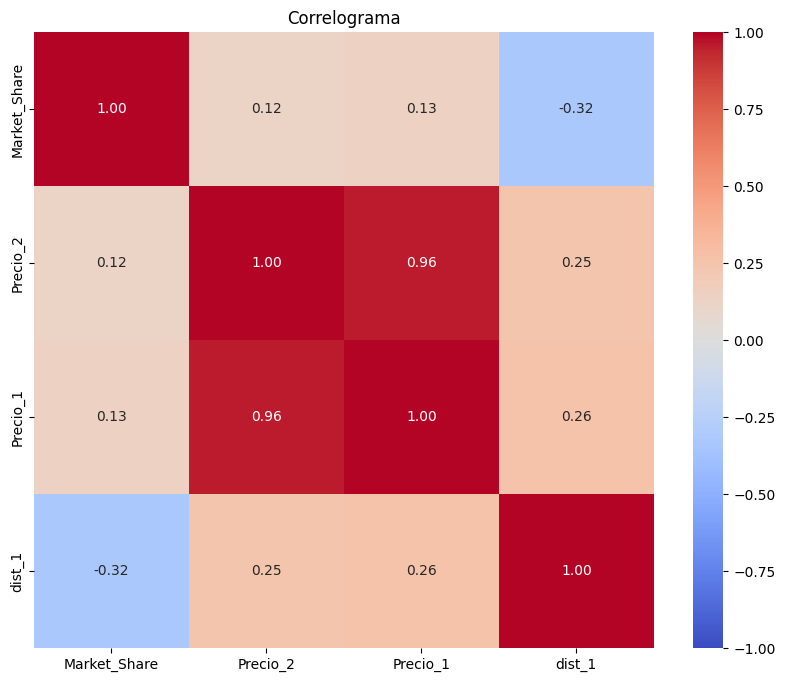

In [385]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlaciones, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlograma')
plt.show()

### Separar los set

In [386]:
## Serie de tiempo

entry_test = dfEntry[dfEntry['Fecha'].isin(['2023-17','2023-18','2023-19','2023-20','2023-21','2023-22','2023-23','2023-24'])]
entry_train =dfEntry[~dfEntry.index.isin(entry_test.index)]
features = ['posicion','Precio_2', 'Precio_1','dist_1'] ## se miraron las correlaciones y se probaron varios modelos para identificar las features
X_train = entry_train.loc[
    ~np.any(entry_train[features].isnull(), axis=1), features
]

y_train = entry_train.loc[X_train.index, 'Market_Share']
X_test = entry_test.loc[:, features]
y_test = entry_test['Market_Share']

### Regresión Lineal

In [387]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
y_predLR = LR_model.predict(X_test)
lr_r_cuadrado = r2_score(y_test, y_predLR)
lr_rmse = np.sqrt(mean_squared_error(y_test,y_predLR))
lr_mape = mean_absolute_percentage_error(y_test,y_predLR)
lr_mse = mean_squared_error(y_test, y_predLR)
lr_mae = mean_absolute_error(y_test, y_predLR)

### Random forest

#### Predicciones

In [388]:
### modelo inicial
### modelo inicial
RF_model_inicial = RandomForestRegressor(
        max_depth=3, n_estimators=100, random_state=59
    )
RF_inicial =  RF_model_inicial.fit(X_train, y_train)
y_predGB = RF_inicial.predict(X_test)
GB_r_cuadrado_i = r2_score(y_test, y_predGB)
GB_mae_i = mean_absolute_error(y_test, y_predGB)
print("R_cuadrado:",GB_r_cuadrado_i)
print("MAE:",GB_mae_i)

R_cuadrado: 0.7827701317380598
MAE: 6.313011604121178


In [389]:
## Optimizacion de hiperparametros
model_params_fit_not_done = True
if model_params_fit_not_done:
    # CV parameter search
    cv_args = {"test_size": 2, "train_size": 3}
    group_col = 'LINEA'
    n_iter = 100
    tscv = GroupTimeSeriesSplit(**cv_args)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(10, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv.split(X_train, groups=entry_train[group_col]),
        scoring="neg_mean_absolute_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    
    model = RandomForestRegressor(
        max_depth=12, n_estimators=53, random_state=59
    )
X_ = dfEntry.loc[:, features]
cv_obj.best_params_

{'max_depth': 12, 'n_estimators': 53}

In [390]:
RF =  model.fit(X_train, y_train)
y_predRF = RF.predict(X_test)
rf_r_cuadrado = r2_score(y_test, y_predRF)
rf_mae = mean_absolute_error(y_test, y_predRF)
print("R_cuadrado:",rf_r_cuadrado)
print("MAE:",rf_mae)

R_cuadrado: 0.9121117937449439
MAE: 3.457852564579953


#### Visualización de las predicciones

In [391]:
dfEntry['predichos']= RF.predict(X_)
dfEntry1=dfEntry[dfEntry['LINEA'] =='REF12']
dfEntry2=dfEntry[dfEntry['LINEA'] =='REF14']
dfEntry3=dfEntry[dfEntry['LINEA'] =='REF19']
dfEntry4=dfEntry[dfEntry['LINEA'] =='REF30']
dfEntry5=dfEntry[dfEntry['LINEA'] =='REF33']

In [392]:
def graficar_datos(df):
    titulo = df['LINEA'].iloc[0]
    plt.figure(figsize=(16, 5))
    plt.plot(df['Fecha'], df['Market_Share'])
    plt.plot(df['Fecha'], df['predichos'])
    plt.plot(df['Fecha'][-8:], df['predichos'][-8:])
    plt.ylabel("Market_share")
    plt.legend(["Real","Prediccion_train" ,"Predicción_test"])
    plt.title(titulo)
    plt.xlabel('Semanas')
    num_etiquetas = len(df['Fecha'])
    n = 4
    plt.xticks(range(0, num_etiquetas, n), df['Fecha'][::n], rotation=45)
    plt.show()

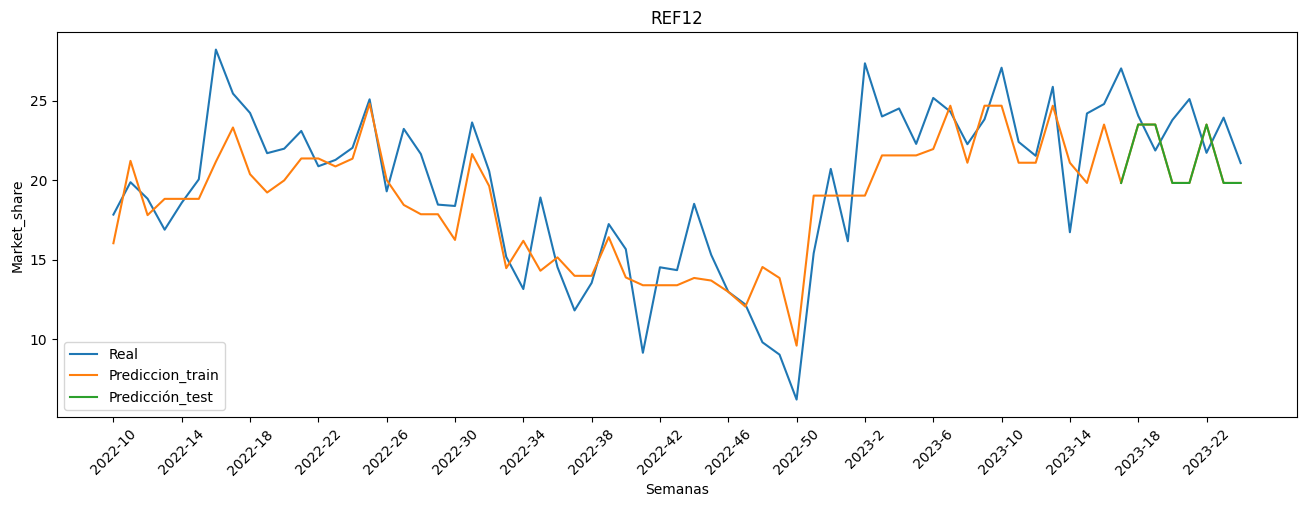

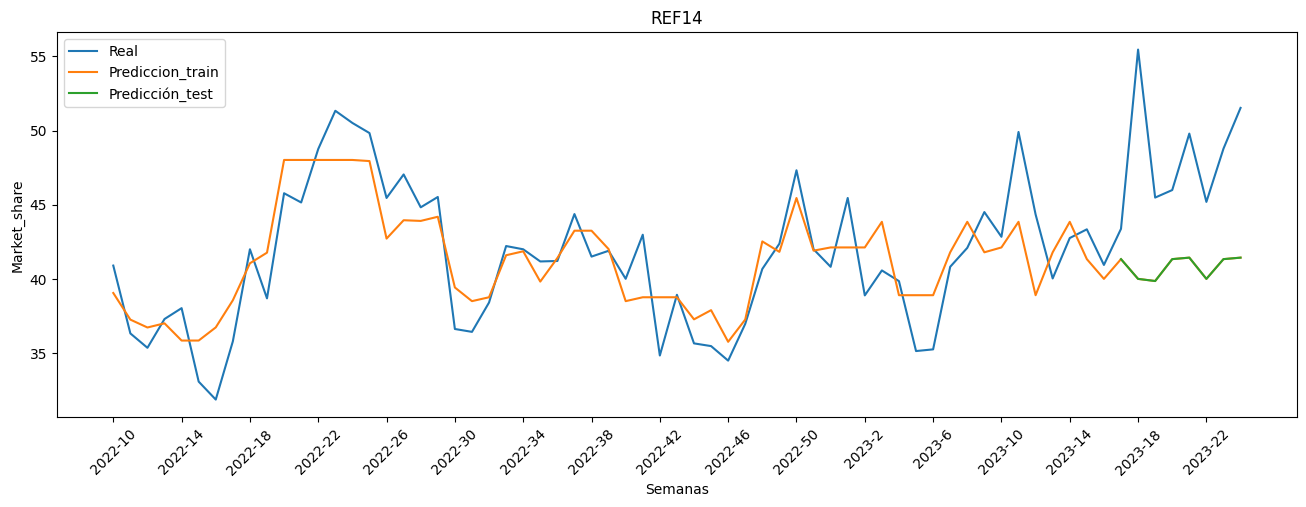

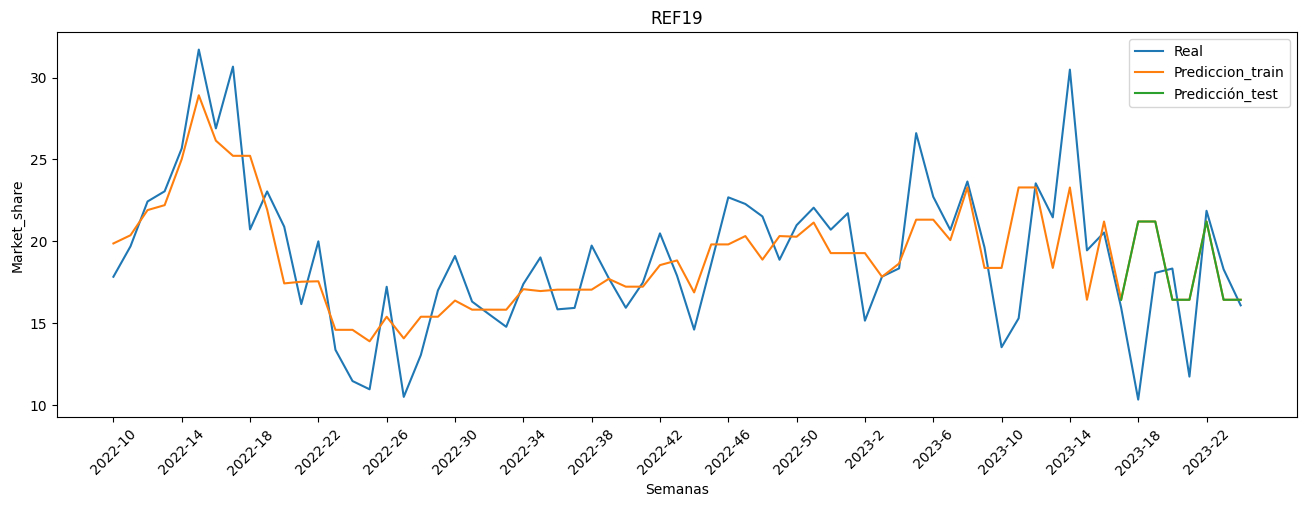

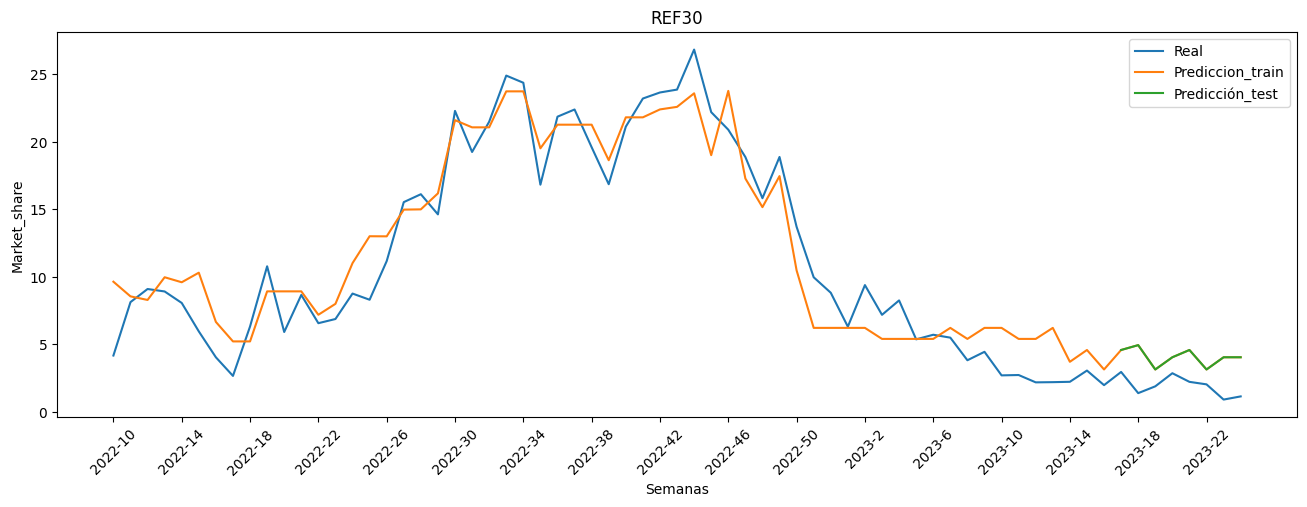

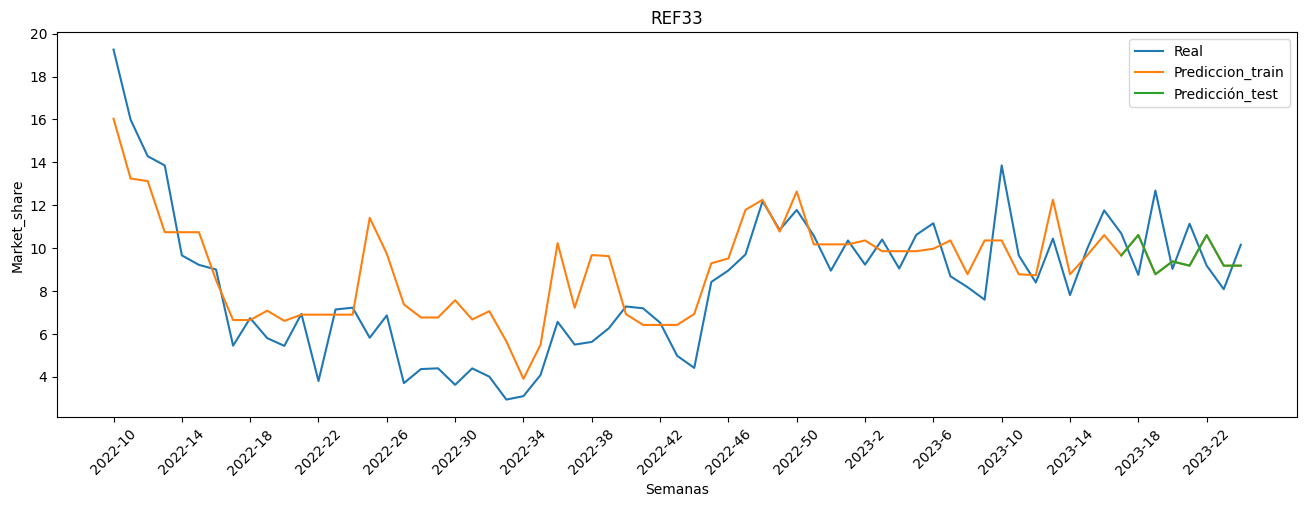

In [393]:
dataEntry = [dfEntry1, dfEntry2, dfEntry3, dfEntry4, dfEntry5]
for df in dataEntry:
    graficar_datos(df)

#### Explicabilidad variables

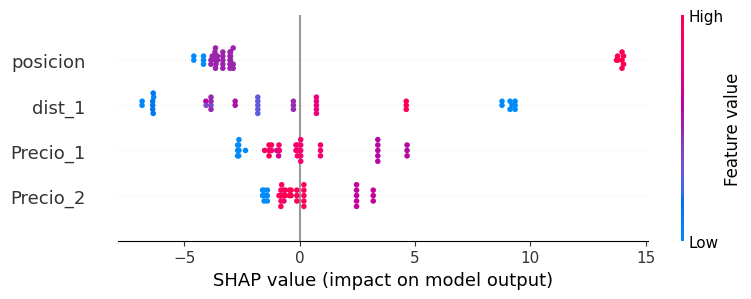

In [394]:
explainer = shap.Explainer(RF, X_test)
# Calcular los SHAP values
shap_values = explainer(X_test)

# Generar un resumen de los SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

#### Intervalo de predicción Random Forest con optimización de parametros

In [395]:
alpha = 0.05

cv_mapiets = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)
mapie_reg = MapieRegressor(estimator=RF, method="base" ,cv=cv_mapiets)
mapie_reg = mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, alpha=0.5)


In [396]:

df_test_entry=pd.DataFrame(entry_test['LINEA'])
df_test_entry['predichos']=y_pred
df_test_entry['test']= y_test
df_test_entry['intervalo_inf']=y_pis[:, 0, 0]
df_test_entry['intervalo_sup']=y_pis[:, 1, 0]
df_test_entry['fecha']=entry_test['Fecha']
referencias =  ['REF12', 'REF14', 'REF19', 'REF30', 'REF33']

df_test_entry_1=df_test_entry[df_test_entry['LINEA']=='REF12']
df_test_entry_2=df_test_entry[df_test_entry['LINEA']=='REF14']
df_test_entry_3=df_test_entry[df_test_entry['LINEA']=='REF19']
df_test_entry_4=df_test_entry[df_test_entry['LINEA']=='REF30']
df_test_entry_5=df_test_entry[df_test_entry['LINEA']=='REF33'] 

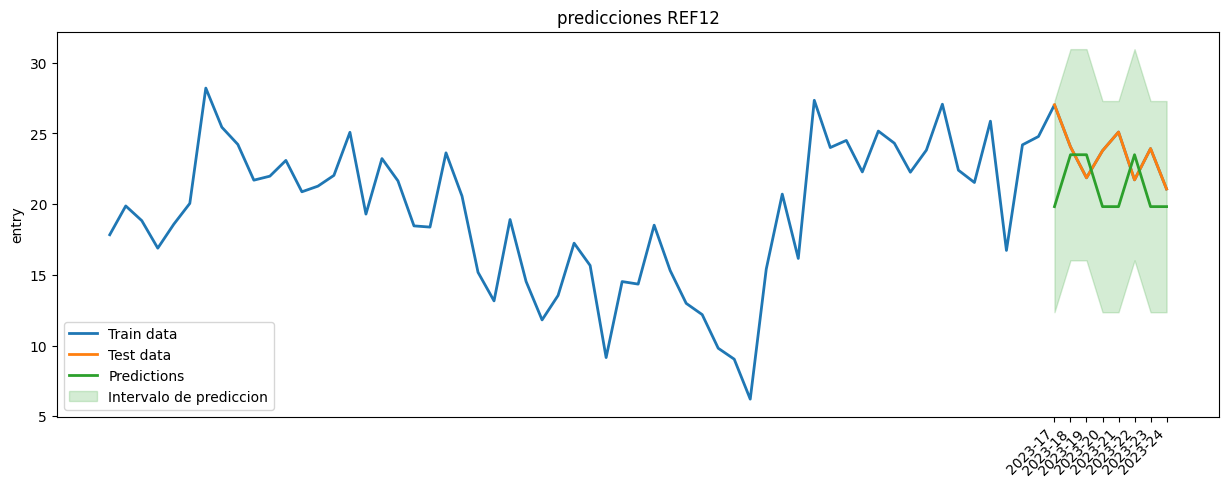

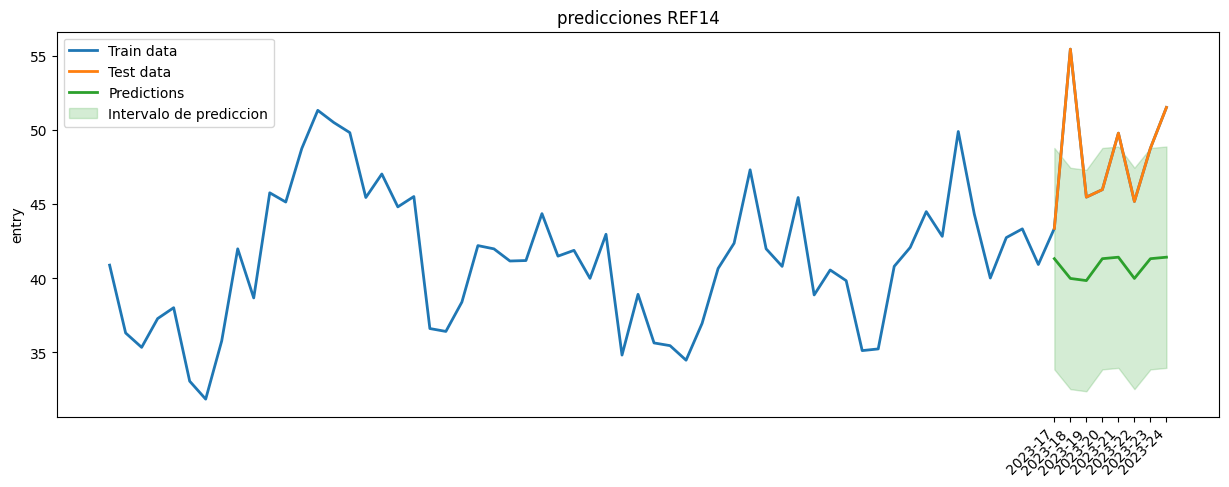

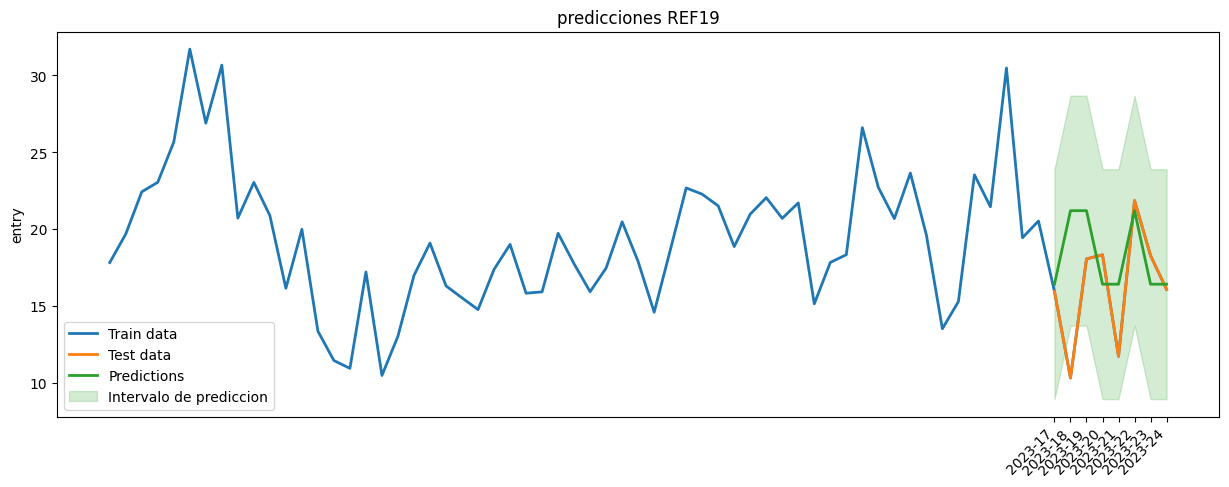

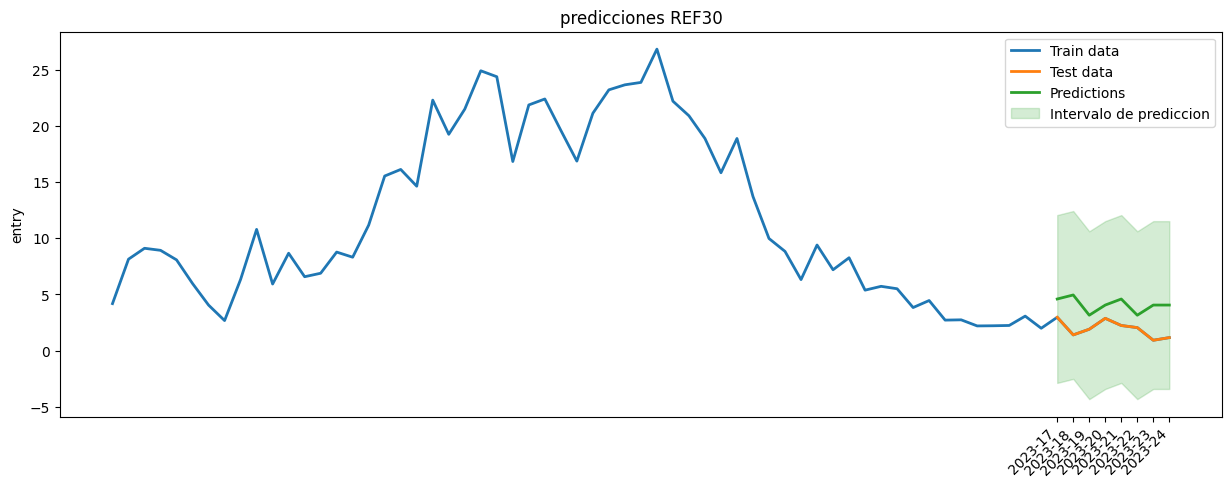

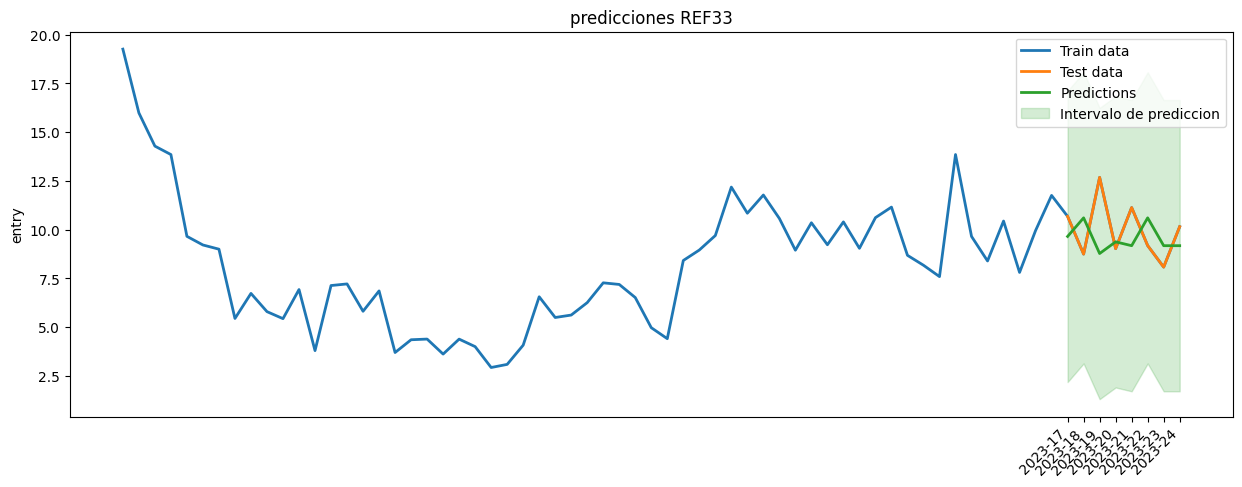

In [397]:
def plot_entry_predictions():
    # Nombres de los DataFrames y los números asociados
    train_numbers = [1, 2, 3, 4, 5]
    test_numbers = [1, 2, 3, 4, 5]
    referencias = ['REF12', 'REF14', 'REF19', 'REF30', 'REF33']

    for train_number, test_number, referencia in zip(train_numbers, test_numbers, referencias):
        # Obtener los DataFrames correspondientes
        dfEntry = globals()[f'dfEntry{train_number}']
        df_test_entry = globals()[f'df_test_entry_{test_number}']

        # Crear el gráfico
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_ylabel("entry")
        #plt.ylim(10, 100)

        # Trazar datos de entrenamiento, datos de prueba y predicciones
        ax.plot(dfEntry['Fecha'].index, dfEntry['Market_Share'], lw=2, label="Train data", c="C0")
        ax.plot(df_test_entry['fecha'].index, df_test_entry['test'], lw=2, label="Test data", c="C1")
        ax.plot(df_test_entry['fecha'].index, df_test_entry['predichos'], lw=2, c="C2", label="Predictions")

        # Trazar intervalos de predicción
        ax.fill_between(
            df_test_entry['fecha'].index,
            df_test_entry['intervalo_inf'],
            df_test_entry['intervalo_sup'],
            color="C2",
            alpha=0.2,
            label="Intervalo de prediccion",
        )

        ax.legend()

        # Establecer valores del eje x como fechas y rotar las etiquetas para una mejor visualización
        ax.set_xticks(df_test_entry['fecha'].index)
        ax.set_xticklabels(df_test_entry['fecha'], rotation=45, ha="right")
        ax.set_title(f"predicciones {referencia}")

        plt.show()

# Uso de la función para generar los 5 gráficos
plot_entry_predictions()

### Gradient Boosting

#### Predicciones

In [398]:
### modelo inicial
GB_model_inicial = GradientBoostingRegressor(
        max_depth=3, n_estimators=100, learning_rate=0.1, random_state=59
    )
GB_inicial =  GB_model_inicial.fit(X_train, y_train)
y_predGB = GB_inicial.predict(X_test)
GB_r_cuadrado_i = r2_score(y_test, y_predGB)
GB_mae_i = mean_absolute_error(y_test, y_predGB)
print("R_cuadrado:",GB_r_cuadrado_i)
print("MAE:",GB_mae_i)

R_cuadrado: 0.9183965464887397
MAE: 3.455198175338798


In [399]:
## Optimizacion de hiperparámetros
model_params_fit_not_done = False

if model_params_fit_not_done:
    # CV parameter search
    cv_args = {"test_size": 2, "train_size": 3}
    group_col = 'LINEA'
    n_iter = 100
    n_splits = 5
    tscv = GroupTimeSeriesSplit(**cv_args)
    random_state = 59
    gb_model = GradientBoostingRegressor(random_state=random_state)
    gb_params = {
        "max_depth": randint(2, 30),
        "n_estimators": randint(10, 100),
        "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.0]
    }
    cv_obj = RandomizedSearchCV(
        gb_model,
        param_distributions=gb_params,
        n_iter=n_iter,
        cv=tscv.split(X_train, groups=entry_train[group_col]),
        scoring="neg_mean_absolute_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    GB_model = cv_obj.best_estimator_
else:
    # Model: Gradient Boosting previously optimized with a cross-validation
    GB_model = GradientBoostingRegressor(
        max_depth=10, n_estimators=53, learning_rate=0.1, random_state=59
    )

X_ = dfEntry.loc[:, features]
cv_obj.best_params_

{'max_depth': 12, 'n_estimators': 53}

In [400]:
#GB_model_P = GradientBoostingRegressor(
#        max_depth=10, n_estimators=50, learning_rate=0.1, random_state=59
#    )
GB =  GB_model.fit(X_train, y_train)
y_predGB = GB.predict(X_test)
GB_r_cuadrado = r2_score(y_test, y_predGB)
GB_mae = mean_absolute_error(y_test, y_predGB)
print("R_cuadrado:",GB_r_cuadrado)
print("MAE:",GB_mae)

R_cuadrado: 0.9272642304256561
MAE: 2.938738648091629


#### Visualización de las predicciones

In [401]:
dfEntry['predichosGB']= GB.predict(X_)
dfEntryGB1=dfEntry[dfEntry['LINEA'] =='REF12']
dfEntryGB2=dfEntry[dfEntry['LINEA'] =='REF14']
dfEntryGB3=dfEntry[dfEntry['LINEA'] =='REF19']
dfEntryGB4=dfEntry[dfEntry['LINEA'] =='REF30']
dfEntryGB5=dfEntry[dfEntry['LINEA'] =='REF33']



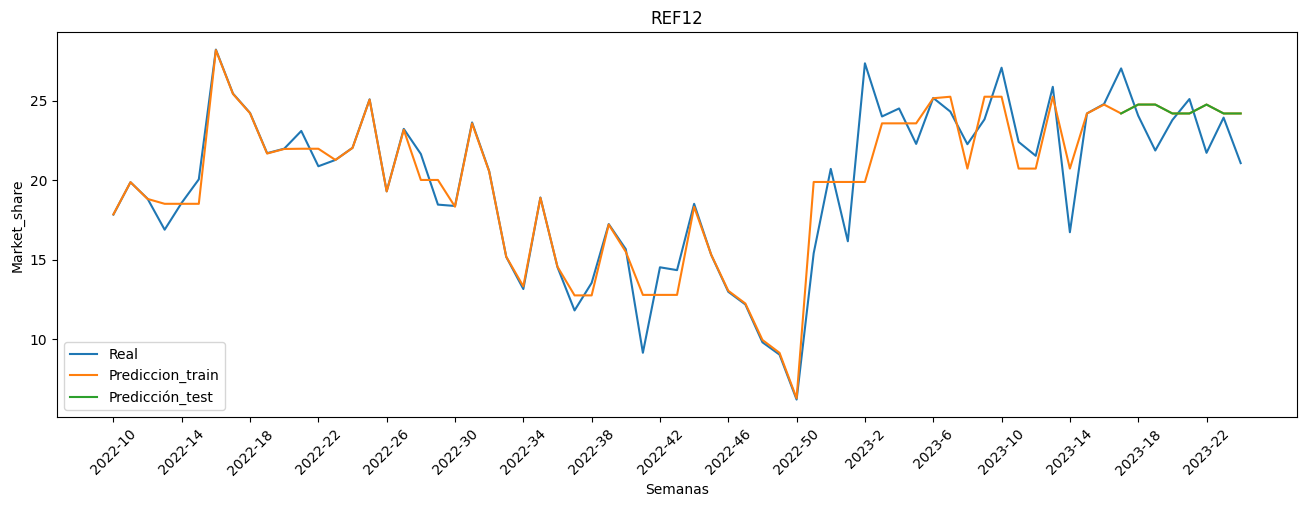

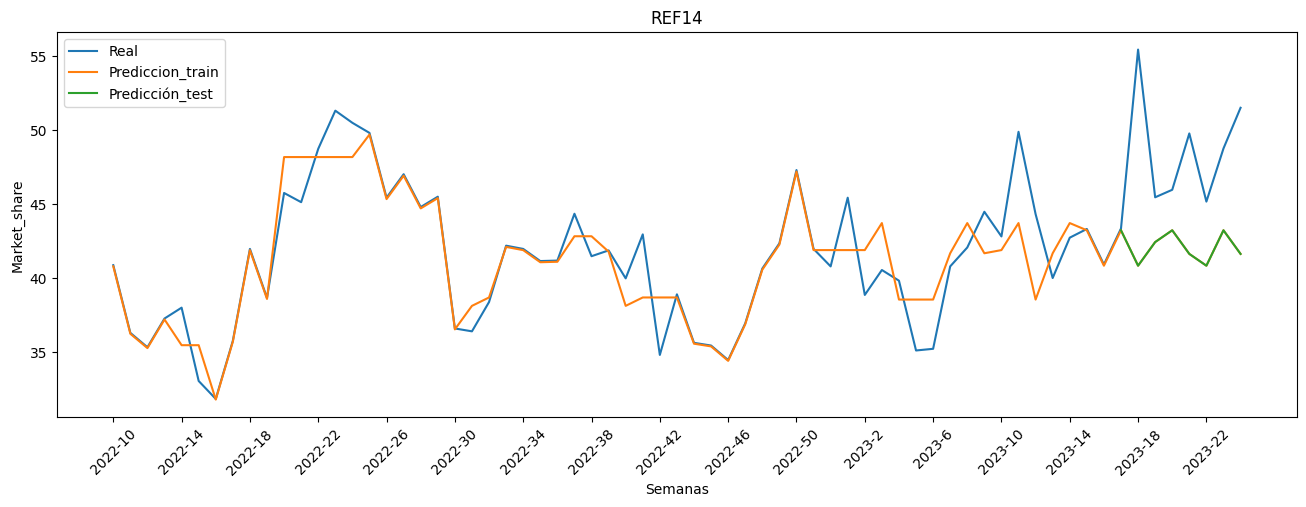

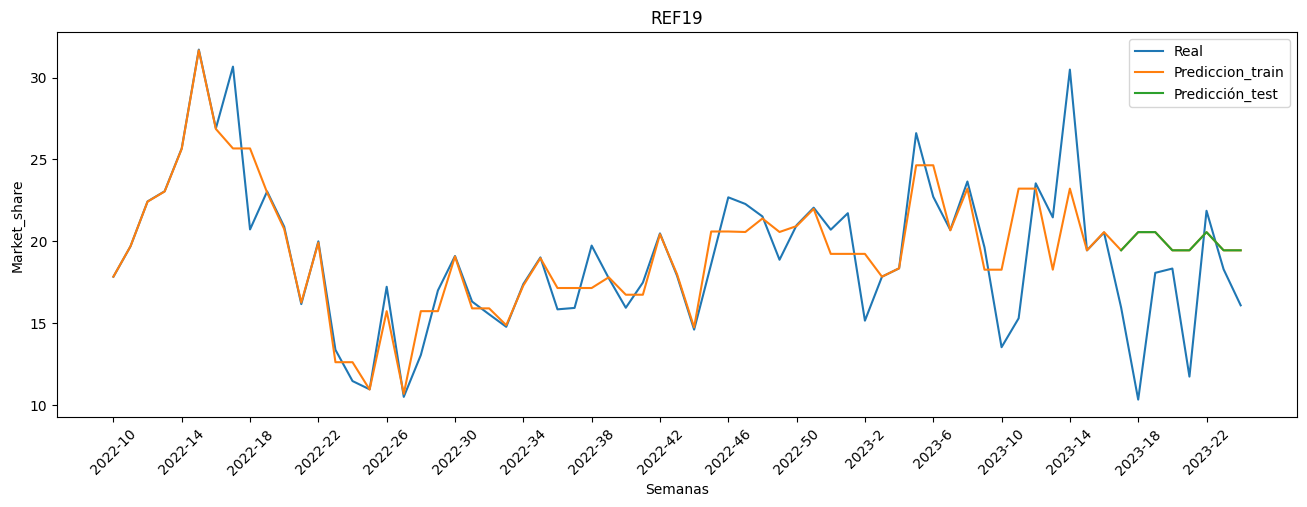

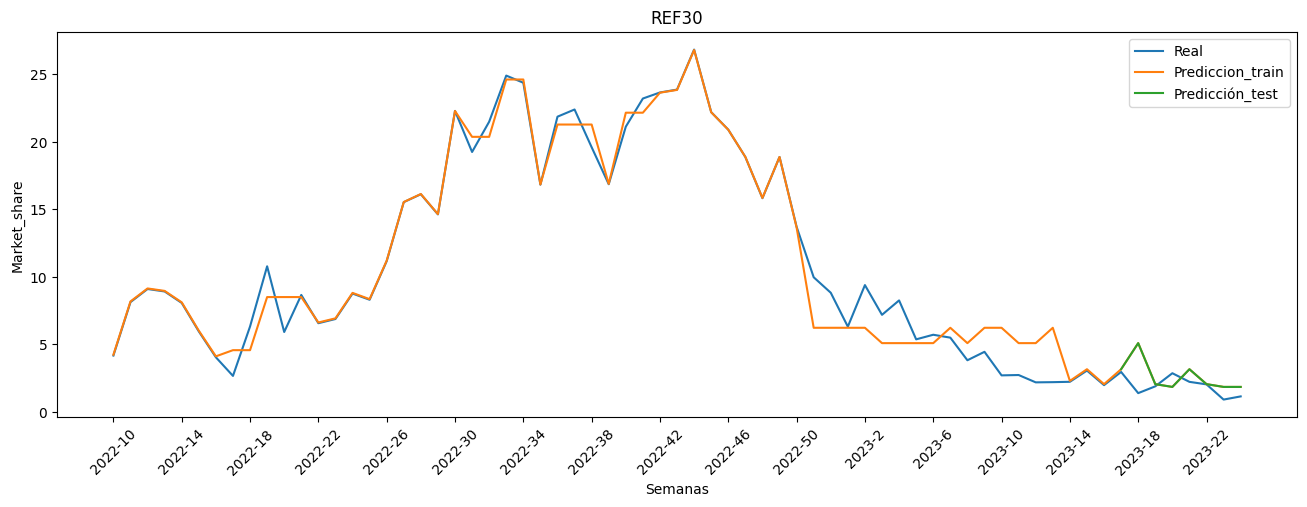

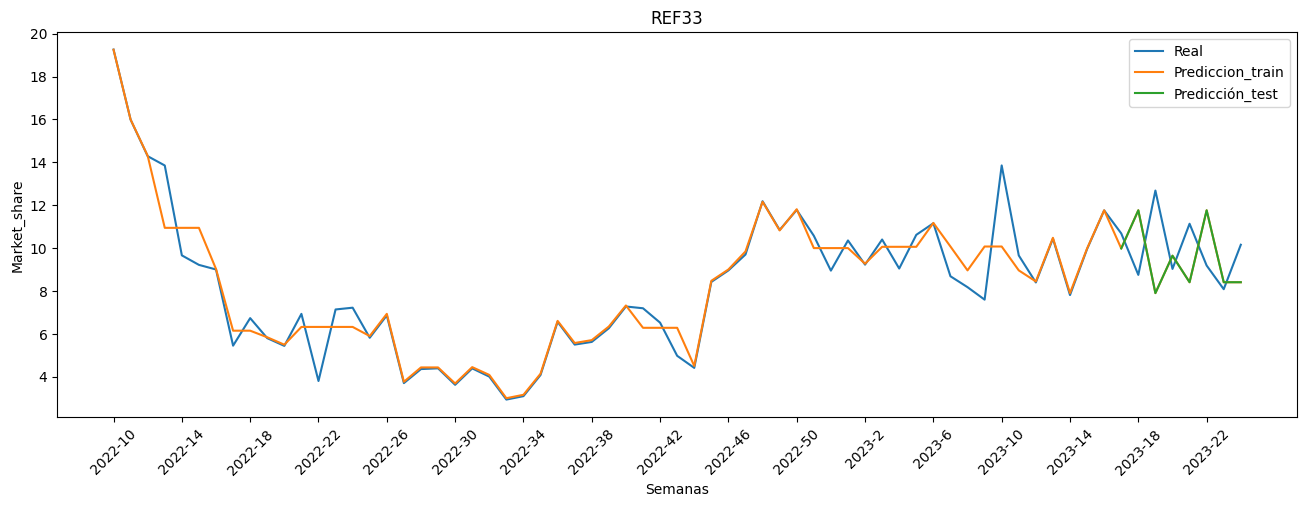

In [402]:
def graficar_datos(df):
    titulo = df['LINEA'].iloc[0]
    plt.figure(figsize=(16, 5))
    plt.plot(df['Fecha'], df['Market_Share'])
    plt.plot(df['Fecha'], df['predichosGB'])
    plt.plot(df['Fecha'][-8:], df['predichosGB'][-8:])
    plt.ylabel("Market_share")
    plt.legend(["Real","Prediccion_train" ,"Predicción_test"])
    plt.title(titulo)
    plt.xlabel('Semanas')
    num_etiquetas = len(df['Fecha'])
    n = 4
    plt.xticks(range(0, num_etiquetas, n), df['Fecha'][::n], rotation=45)
    plt.show()
dataEntry = [dfEntryGB1, dfEntryGB2, dfEntryGB3, dfEntryGB4, dfEntryGB5]
for df in dataEntry:
    graficar_datos(df)

#### Explicabilidad

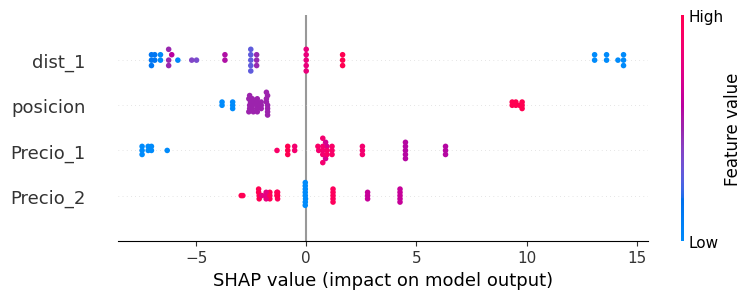

In [403]:
explainer = shap.Explainer(GB, X_test)
# Calcular los SHAP values
shap_values = explainer(X_test)

# Generar un resumen de los SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

#### Intervalo de predicción gradient boosting

In [404]:
alpha = 0.05

cv_mapiets = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)
mapie_reg = MapieRegressor(estimator=GB, method="base" ,cv=cv_mapiets)
mapie_reg = mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, alpha=0.5)


In [405]:

df_test_entryGB=pd.DataFrame(entry_test['LINEA'])
df_test_entryGB['predichos']=y_pred
df_test_entryGB['test']= y_test
df_test_entryGB['intervalo_inf']=y_pis[:, 0, 0]
df_test_entryGB['intervalo_sup']=y_pis[:, 1, 0]
df_test_entryGB['fecha']=entry_test['Fecha']
referencias =  ['REF12', 'REF14', 'REF19', 'REF30', 'REF33']

df_test_entry_GB1=df_test_entryGB[df_test_entryGB['LINEA']=='REF12']
df_test_entry_GB2=df_test_entryGB[df_test_entryGB['LINEA']=='REF14']
df_test_entry_GB3=df_test_entryGB[df_test_entryGB['LINEA']=='REF19']
df_test_entry_GB4=df_test_entryGB[df_test_entryGB['LINEA']=='REF30']
df_test_entry_GB5=df_test_entryGB[df_test_entryGB['LINEA']=='REF33'] 

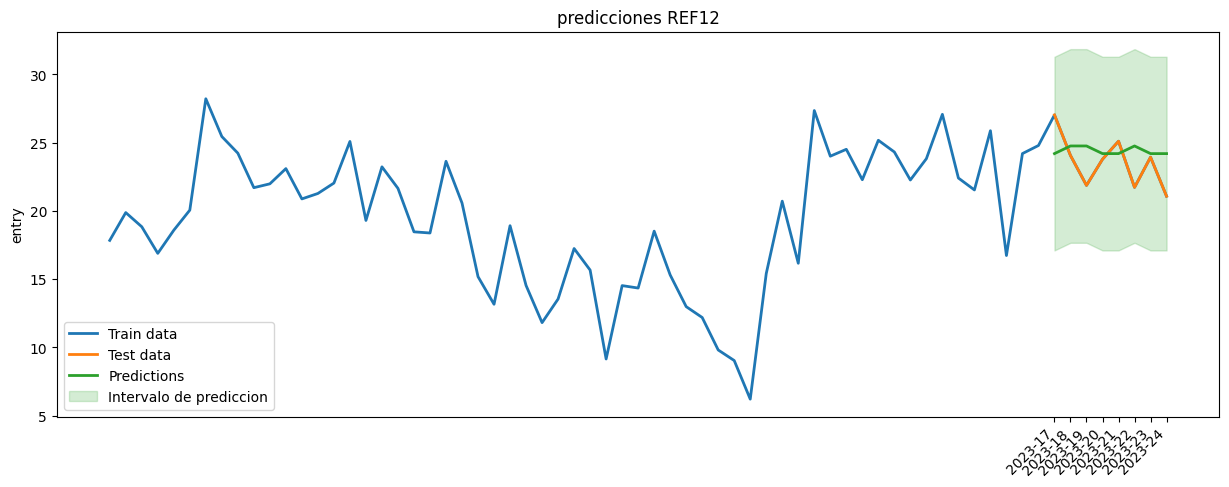

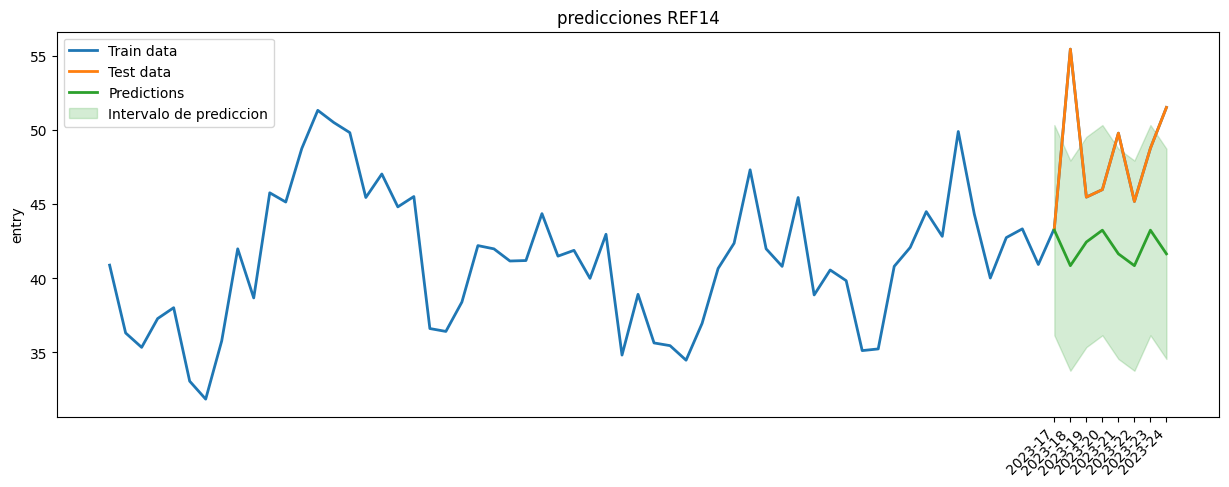

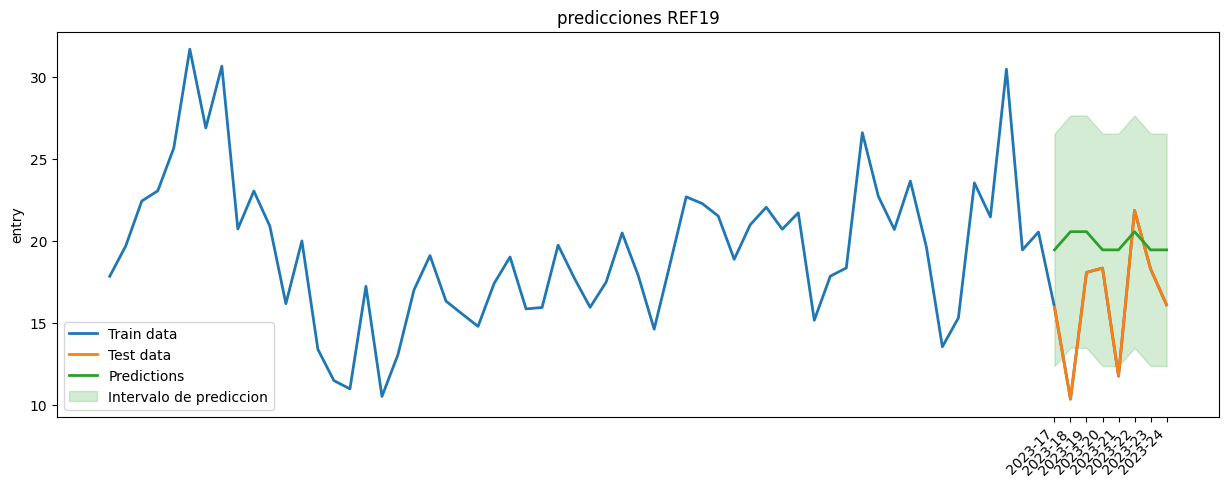

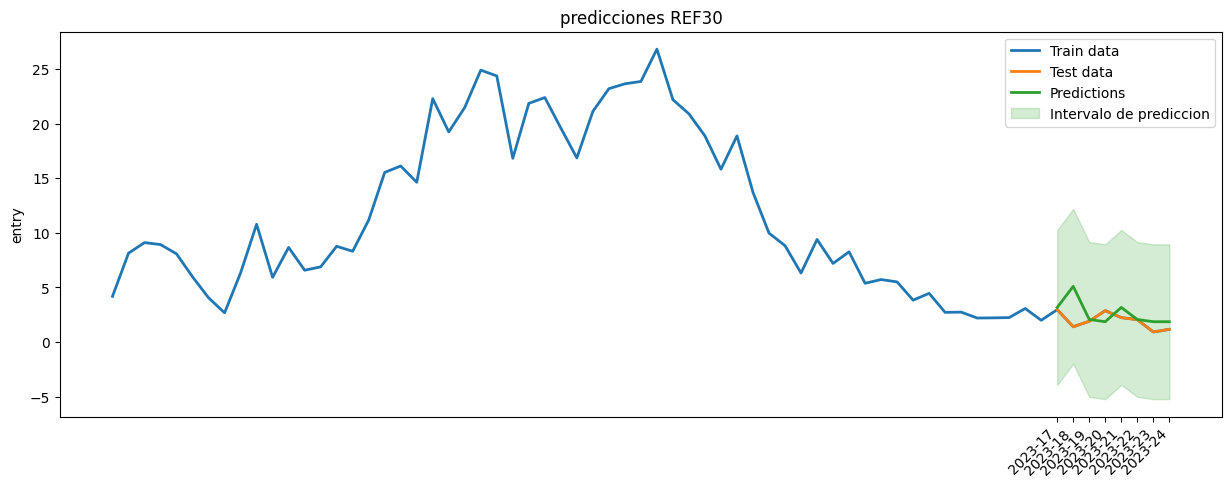

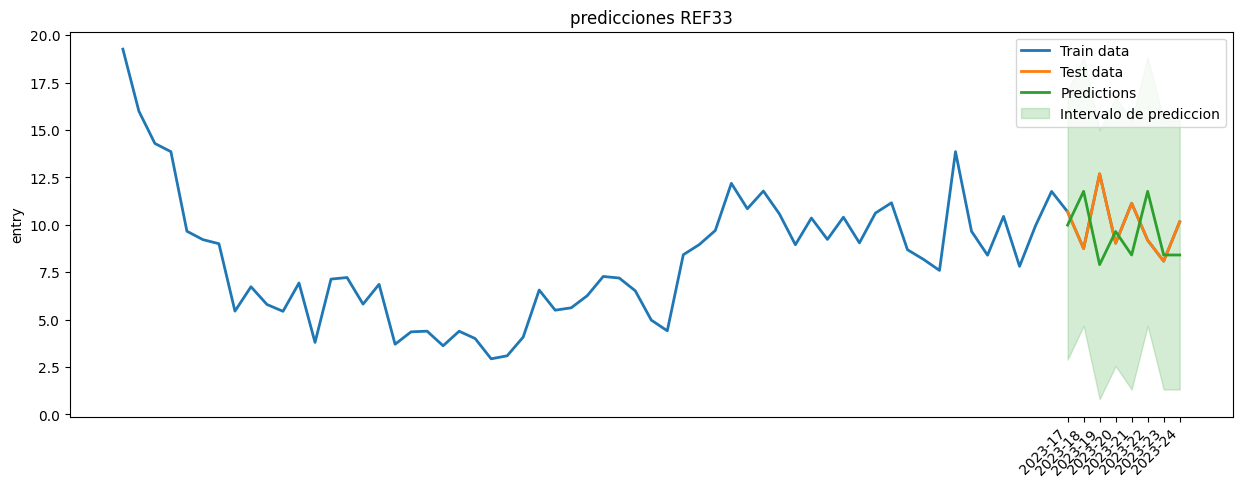

In [406]:
def plot_entry_predictions():
    # Nombres de los DataFrames y los números asociados
    train_numbers = [1, 2, 3, 4, 5]
    test_numbers = [1, 2, 3, 4, 5]
    referencias = ['REF12', 'REF14', 'REF19', 'REF30', 'REF33']

    for train_number, test_number, referencia in zip(train_numbers, test_numbers, referencias):
        # Obtener los DataFrames correspondientes
        dfEntry = globals()[f'dfEntryGB{train_number}']
        df_test_entryGB = globals()[f'df_test_entry_GB{test_number}']

        # Crear el gráfico
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_ylabel("entry")
        #plt.ylim(10, 100)

        # Trazar datos de entrenamiento, datos de prueba y predicciones
        ax.plot(dfEntry['Fecha'].index, dfEntry['Market_Share'], lw=2, label="Train data", c="C0")
        ax.plot(df_test_entryGB['fecha'].index, df_test_entryGB['test'], lw=2, label="Test data", c="C1")
        ax.plot(df_test_entryGB['fecha'].index, df_test_entryGB['predichos'], lw=2, c="C2", label="Predictions")

        # Trazar intervalos de predicción
        ax.fill_between(
            df_test_entryGB['fecha'].index,
            df_test_entryGB['intervalo_inf'],
            df_test_entryGB['intervalo_sup'],
            color="C2",
            alpha=0.2,
            label="Intervalo de prediccion",
        )

        ax.legend()

        # Establecer valores del eje x como fechas y rotar las etiquetas para una mejor visualización
        ax.set_xticks(df_test_entryGB['fecha'].index)
        ax.set_xticklabels(df_test_entryGB['fecha'], rotation=45, ha="right")
        ax.set_title(f"predicciones {referencia}")

        plt.show()

# Uso de la función para generar los 5 gráficos
plot_entry_predictions()

### LightGBM

#### Predicciones

In [407]:

model_lgbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=100)
    
LGBM= model_lgbm.fit(X_train, y_train)
predicted_y = model_lgbm.predict(X_test)
LGBM_r_cuadrado = r2_score(y_test, predicted_y)
LGBM_mae = mean_absolute_error(y_test, predicted_y)
print("R_cuadrado:",LGBM_r_cuadrado)
print("MAE:",LGBM_mae)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 4
[LightGBM] [Info] Start training from score 20.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [408]:
model_params_fit_not_done = True
if model_params_fit_not_done:
    # CV parameter search
    cv_args = {"test_size": 2, "train_size": 3}
    group_col = 'LINEA'
    n_iter = 100
    tscv = GroupTimeSeriesSplit(**cv_args)
    random_state = 59
    lgbm_model = lgb.LGBMRegressor(random_state=random_state)
    lgb_params = {"max_depth": randint(2, 30),"num_leaves": randint(10, 40), "n_estimators": randint(10, 100),"learning_rate": [0.001, 0.01, 0.1, 0.5, 0.8] }
    cv_obj = RandomizedSearchCV(
        lgbm_model,
        param_distributions=lgb_params,
        n_iter=n_iter,
        cv=tscv.split(X_train, groups=entry_train[group_col]),
        scoring="neg_mean_absolute_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    
    model = lgb.LGBMRegressor(
        learning_rate=0.5, n_estimators=53, random_state=59, num_leaves=13
    )
X_ = dfEntry.loc[:, features]
print(cv_obj.best_params_)
LGBM =  model.fit(X_train, y_train)
y_predLGBM = LGBM.predict(X_test)
LGBM_r_cuadrado = r2_score(y_test, y_predLGBM)
LGBM_mae = mean_absolute_error(y_test, y_predLGBM)
print("R_cuadrado:",LGBM_r_cuadrado)
print("MAE:",LGBM_mae)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 4
[LightGBM] [Info] Start training from score 20.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [409]:
LGBM =  model.fit(X_train, y_train)
y_predLGBM = LGBM.predict(X_test)
LGBM_r_cuadrado = r2_score(y_test, y_predLGBM)
LGBM_mae = mean_absolute_error(y_test, y_predLGBM)
print("R_cuadrado:",LGBM_r_cuadrado)
print("MAE:",LGBM_mae)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 148
[LightGBM] [Info] Number of data points in the train set: 295, number of used features: 4
[LightGBM] [Info] Start training from score 20.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

#### Visualización de la predicción

In [410]:
dfEntry['predichosLGBM']= LGBM.predict(X_)
dfEntryLGBM1=dfEntry[dfEntry['LINEA'] =='REF12']
dfEntryLGBM2=dfEntry[dfEntry['LINEA'] =='REF14']
dfEntryLGBM3=dfEntry[dfEntry['LINEA'] =='REF19']
dfEntryLGBM4=dfEntry[dfEntry['LINEA'] =='REF30']
dfEntryLGBM5=dfEntry[dfEntry['LINEA'] =='REF33']

In [411]:
def graficar_datos(df):
    titulo = df['LINEA'].iloc[0]
    plt.figure(figsize=(16, 5))
    plt.plot(df['Fecha'], df['Market_Share'])
    plt.plot(df['Fecha'], df['predichosLGBM'])
    plt.plot(df['Fecha'][-8:], df['predichosLGBM'][-8:])
    plt.ylabel("Market_share")
    plt.legend(["Real","Prediccion_train" ,"Predicción_test"])
    plt.title(titulo)
    plt.xlabel('Semanas')
    num_etiquetas = len(df['Fecha'])
    n = 4
    plt.xticks(range(0, num_etiquetas, n), df['Fecha'][::n], rotation=45)
    plt.show()

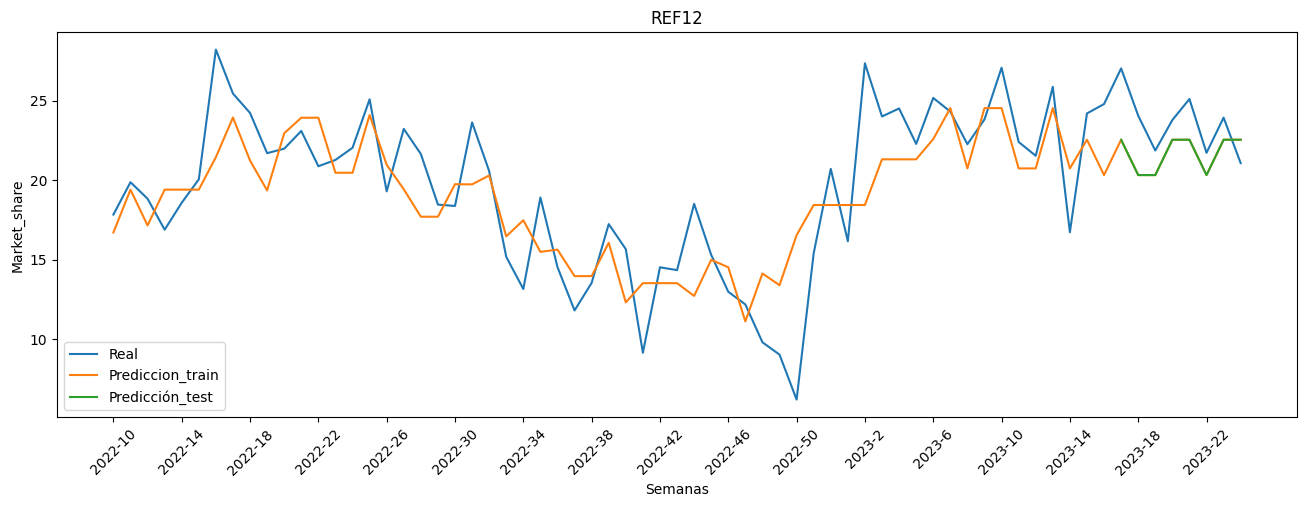

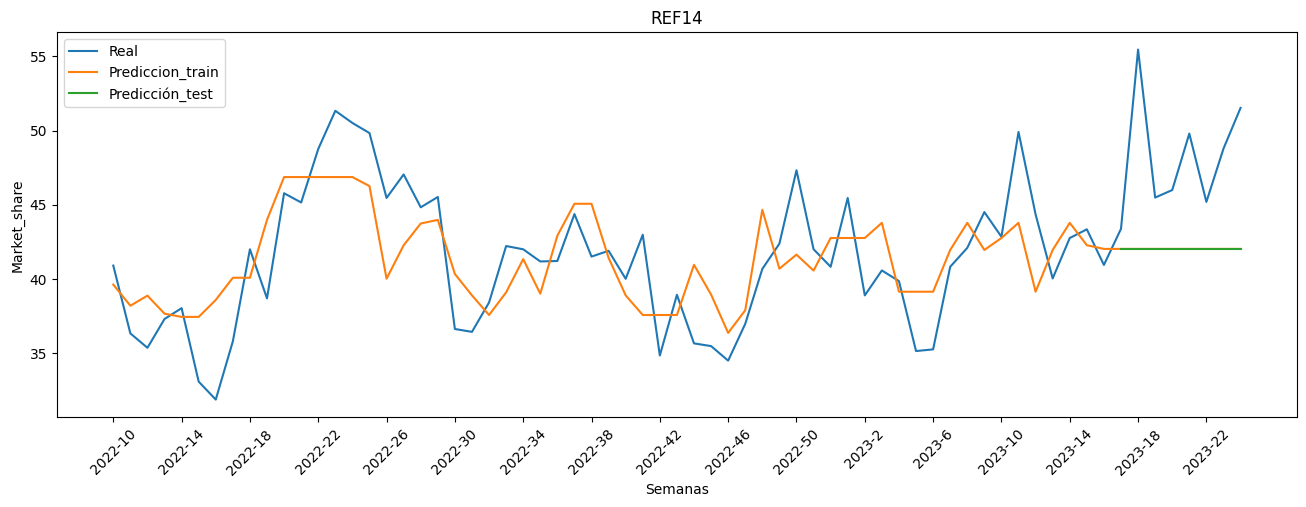

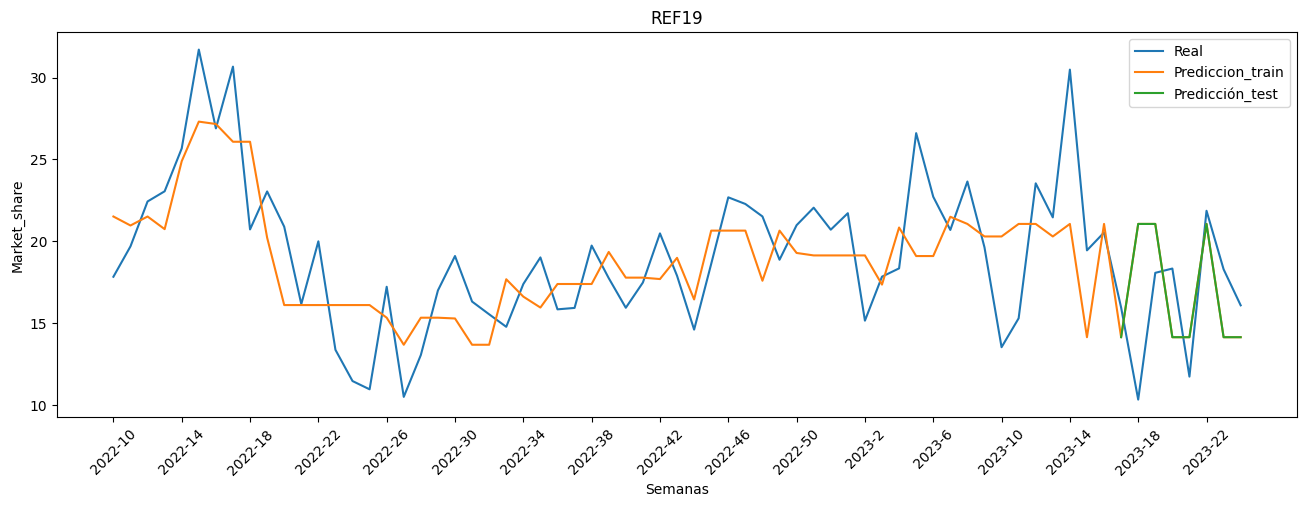

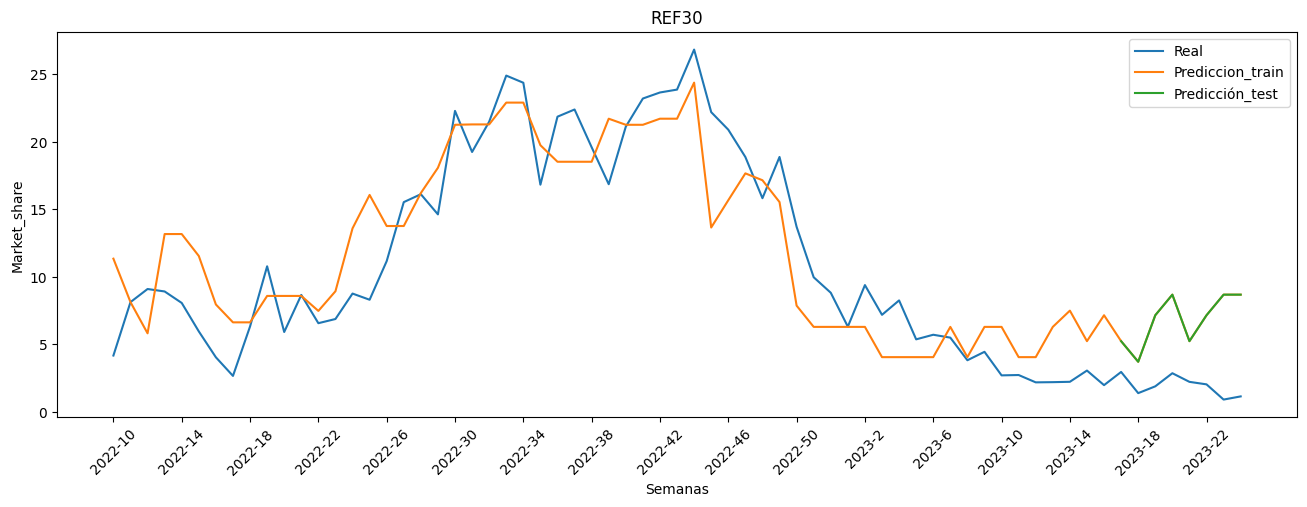

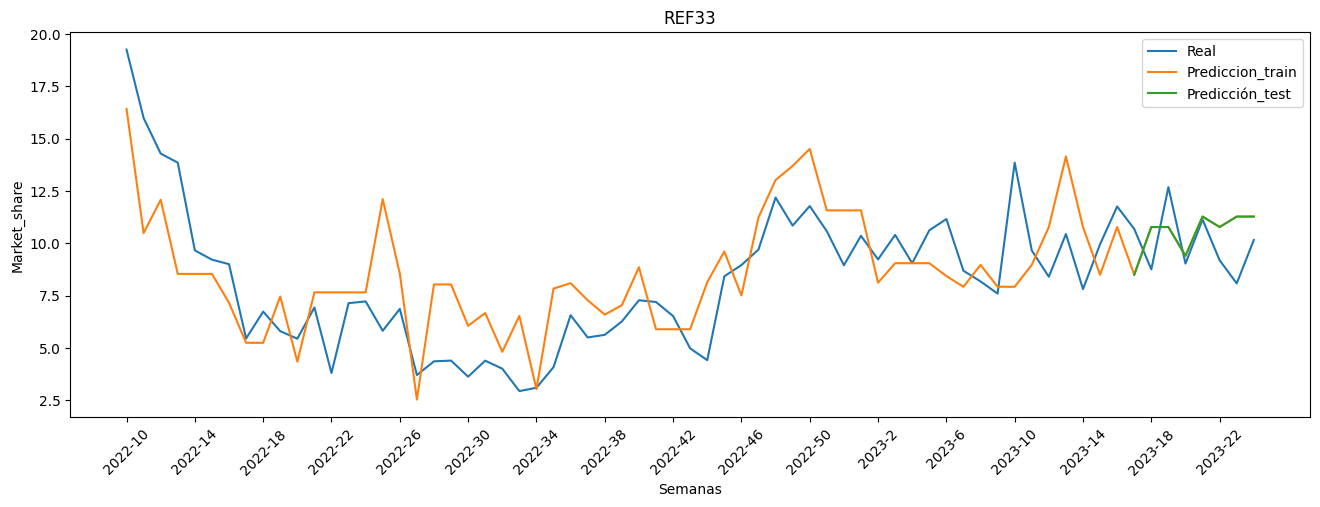

In [412]:
dataEntry = [dfEntryLGBM1, dfEntryLGBM2, dfEntryLGBM3, dfEntryLGBM4, dfEntryLGBM5]
for df in dataEntry:
    graficar_datos(df)

#### Explicabilidad de las variables

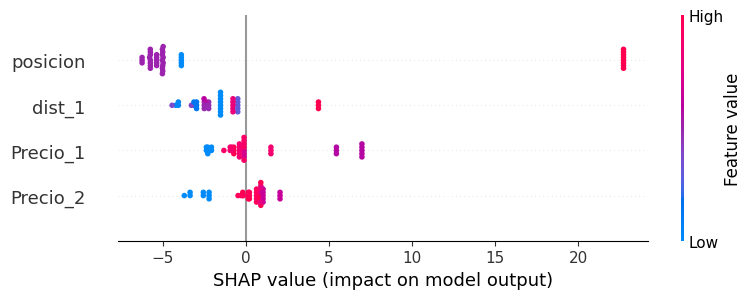

In [413]:
explainer = shap.Explainer(LGBM)
# Calcular los SHAP values
shap_values = explainer(X_test)

# Generar un resumen de los SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

### XGBOOST

#### Predicciones

In [414]:
# Acercamiento inicial
xgboost_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=random_state)


xgboost_model.fit(X_train, y_train)


y_predXGB = xgboost_model.predict(X_test)

xgboost_r_cuadrado = r2_score(y_test, y_predXGB)
xgboost_rmse = np.sqrt(mean_squared_error(y_test,y_predXGB))
xgboost_mape = mean_absolute_percentage_error(y_test,y_predXGB)
xgboost_mse = mean_squared_error(y_test, y_predXGB)
xgboost_mae = mean_absolute_error(y_test, y_predXGB)
print("R_cuadrado:",xgboost_r_cuadrado)
print("MAE:",xgboost_mae)

R_cuadrado: 0.9065797495938198
MAE: 3.935252361800328


In [415]:
# Optimización de Hiperparametros

model_params_fit_not_done = False
if model_params_fit_not_done:
    # CV parameter search
    cv_args = {"test_size": 2, "train_size": 3}
    group_col = 'LINEA'
    n_iter = 100
    tscv = GroupTimeSeriesSplit(**cv_args)
    random_state = 59
    xgboost_model = xgb.XGBRegressor(random_state=random_state)
    xgboost_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 200), "learning_rate": [0.001, 0.05 ,0.01, 0.1, 0.5, 1.0],
                 "subsample": [0.5, 0.7, 0.8, 1.0],"colsample_bytree": [0.5, 0.7, 0.8, 1.0] }
    cv_obj = RandomizedSearchCV(
        xgboost_model,
        param_distributions=xgboost_params,
        n_iter=n_iter,
        cv=tscv.split(X_train, groups=entry_train[group_col]),
        scoring="neg_mean_absolute_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    
    model = xgb.XGBRegressor(
        n_estimators=45, learning_rate=0.1, max_depth=11, random_state=random_state, subsample=0.8
    )
X_ = dfEntry.loc[:, features]
print(cv_obj.best_params_)
XGBOOST =  model.fit(X_train, y_train)
y_predXGBOOST = XGBOOST.predict(X_test)
XGBOOST_r_cuadrado = r2_score(y_test, y_predXGBOOST)
XGBOOST_mae = mean_absolute_error(y_test, y_predXGBOOST)
print("R_cuadrado:",XGBOOST_r_cuadrado)
print("MAE:",XGBOOST_mae)

{'learning_rate': 0.8, 'max_depth': 26, 'n_estimators': 18, 'num_leaves': 17}
R_cuadrado: 0.9204899234079242
MAE: 3.1445062004778435


In [416]:
XGBOOST =  model.fit(X_train, y_train)
y_predXGBOOST = XGBOOST.predict(X_test)
XGBOOST_r_cuadrado = r2_score(y_test, y_predXGBOOST)
XGBOOST_mae = mean_absolute_error(y_test, y_predXGBOOST)
print("R_cuadrado:",XGBOOST_r_cuadrado)
print("MAE:",XGBOOST_mae)

R_cuadrado: 0.9204899234079242
MAE: 3.1445062004778435


#### Visualización de predicciones

In [417]:
dfEntry['predichosXGBOOST']= XGBOOST.predict(X_)
dfEntryXGB1=dfEntry[dfEntry['LINEA'] =='REF12']
dfEntryXGB2=dfEntry[dfEntry['LINEA'] =='REF14']
dfEntryXGB3=dfEntry[dfEntry['LINEA'] =='REF19']
dfEntryXGB4=dfEntry[dfEntry['LINEA'] =='REF30']
dfEntryXGB5=dfEntry[dfEntry['LINEA'] =='REF33']

In [418]:
def graficar_datos(df):
    titulo = df['LINEA'].iloc[0]
    plt.figure(figsize=(16, 5))
    plt.plot(df['Fecha'], df['Market_Share'])
    plt.plot(df['Fecha'], df['predichosXGBOOST'])
    plt.plot(df['Fecha'][-8:], df['predichosXGBOOST'][-8:])
    plt.ylabel("Market_share")
    plt.legend(["Real","Prediccion_train" ,"Predicción_test"])
    plt.title(titulo)
    plt.xlabel('Semanas')
    num_etiquetas = len(df['Fecha'])
    n = 4
    plt.xticks(range(0, num_etiquetas, n), df['Fecha'][::n], rotation=45)
    plt.show()

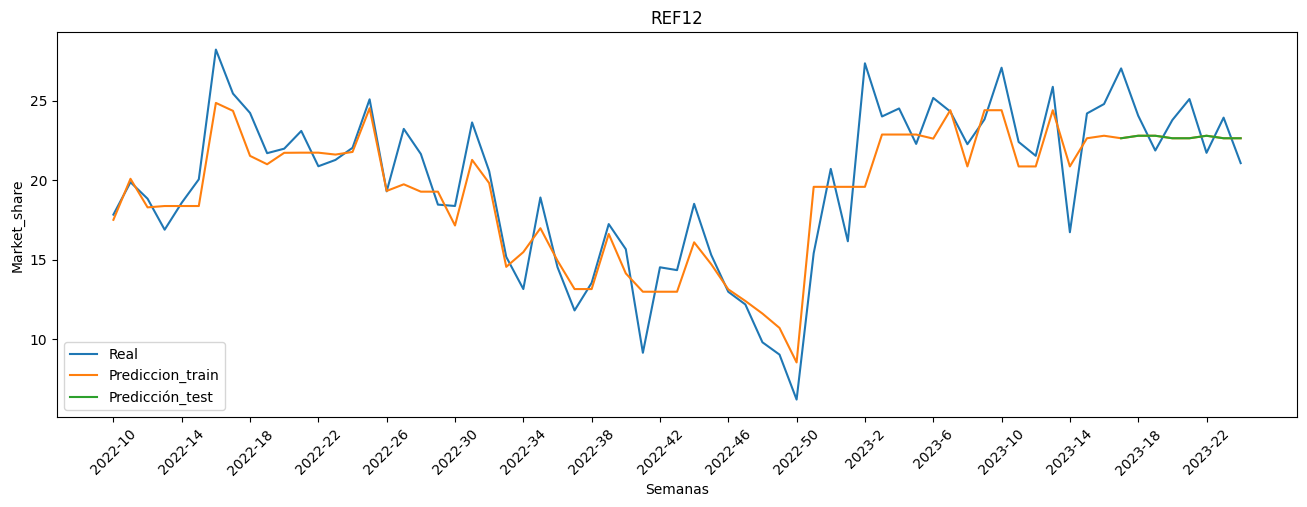

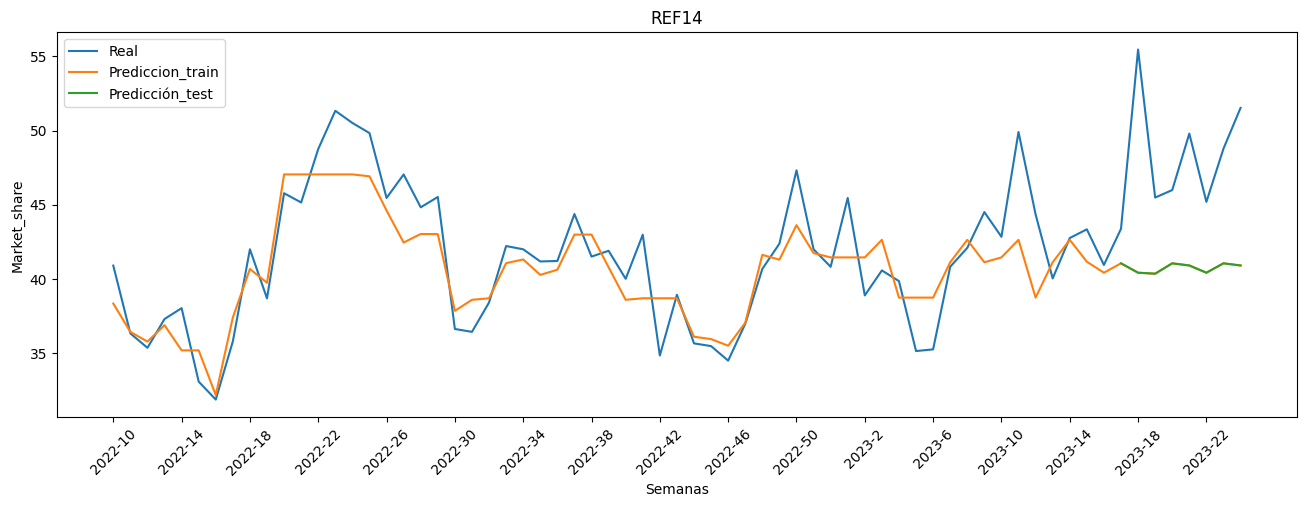

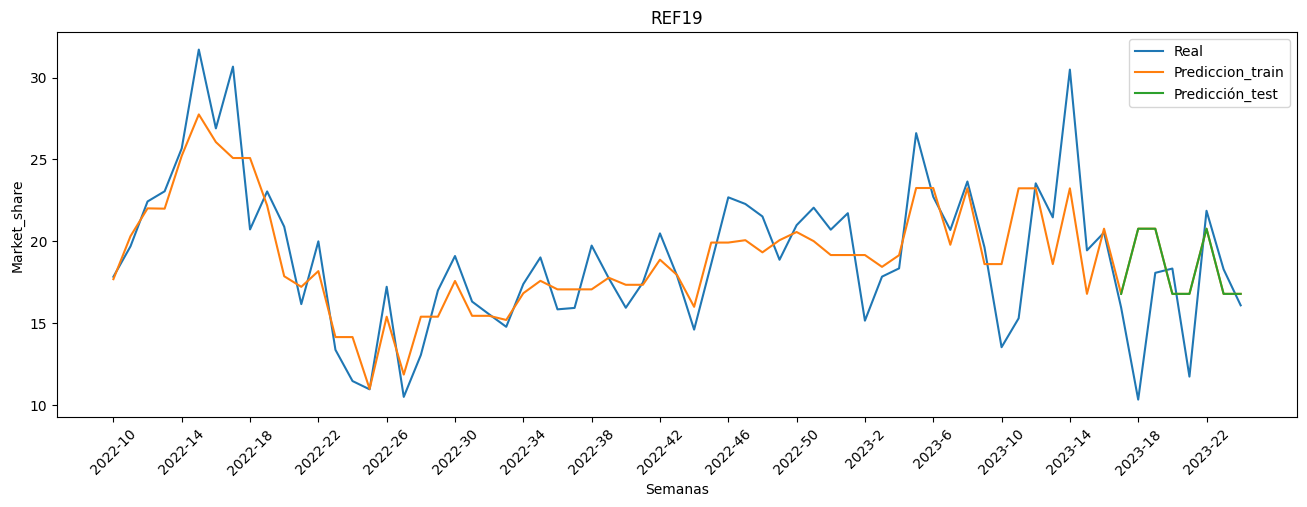

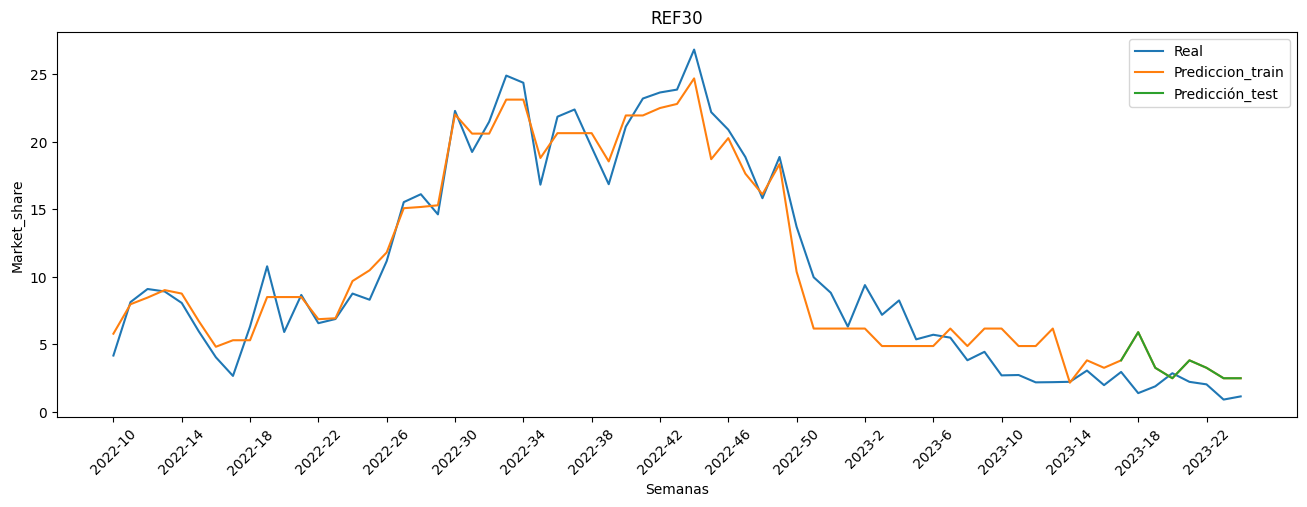

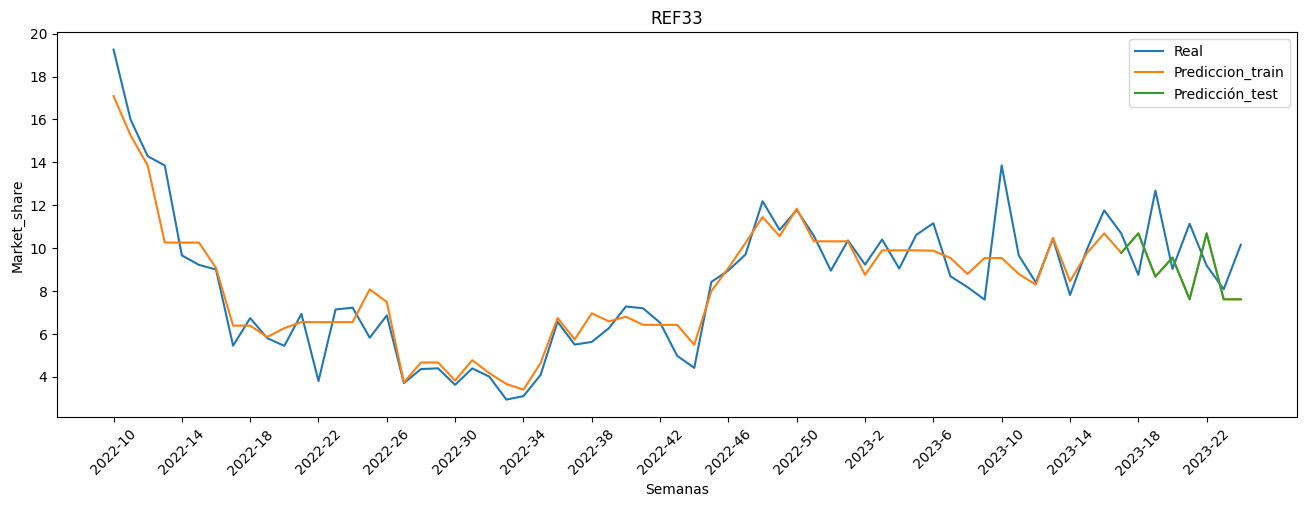

In [419]:
dataEntry = [dfEntryXGB1, dfEntryXGB2, dfEntryXGB3, dfEntryXGB4, dfEntryXGB5]
for df in dataEntry:
    graficar_datos(df)

#### Explicabilidad de las variables

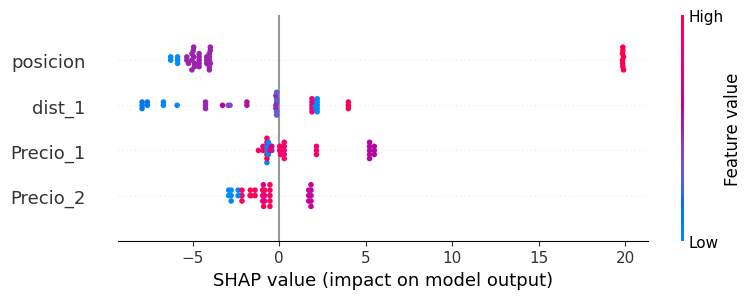

In [420]:
explainer = shap.Explainer(XGBOOST)
# Calcular los SHAP values
shap_values = explainer(X_test)

# Generar un resumen de los SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

#### Intervalos de predicción

In [423]:

alpha = 0.05

cv_mapiets = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)
mapie_reg = MapieRegressor(estimator=XGBOOST, method="base" ,cv=cv_mapiets)
mapie_reg = mapie_reg.fit(X_train, y_train)
y_pred, y_pis = mapie_reg.predict(X_test, alpha=0.5)

In [424]:
df_test_entry=pd.DataFrame(entry_test['LINEA'])
df_test_entry['predichos']=y_pred
df_test_entry['test']= y_test
df_test_entry['intervalo_inf']=y_pis[:, 0, 0]
df_test_entry['intervalo_sup']=y_pis[:, 1, 0]
df_test_entry['fecha']=entry_test['Fecha']
referencias =  ['REF12', 'REF14', 'REF19', 'REF30', 'REF33']

df_test_entry_1=df_test_entry[df_test_entry['LINEA']=='REF12']
df_test_entry_2=df_test_entry[df_test_entry['LINEA']=='REF14']
df_test_entry_3=df_test_entry[df_test_entry['LINEA']=='REF19']
df_test_entry_4=df_test_entry[df_test_entry['LINEA']=='REF30']
df_test_entry_5=df_test_entry[df_test_entry['LINEA']=='REF33'] 

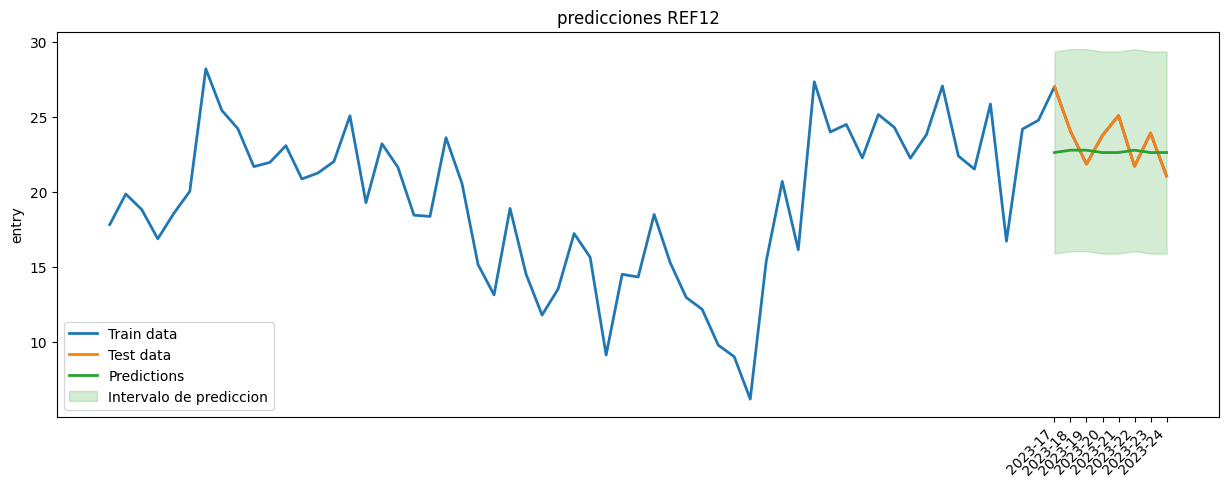

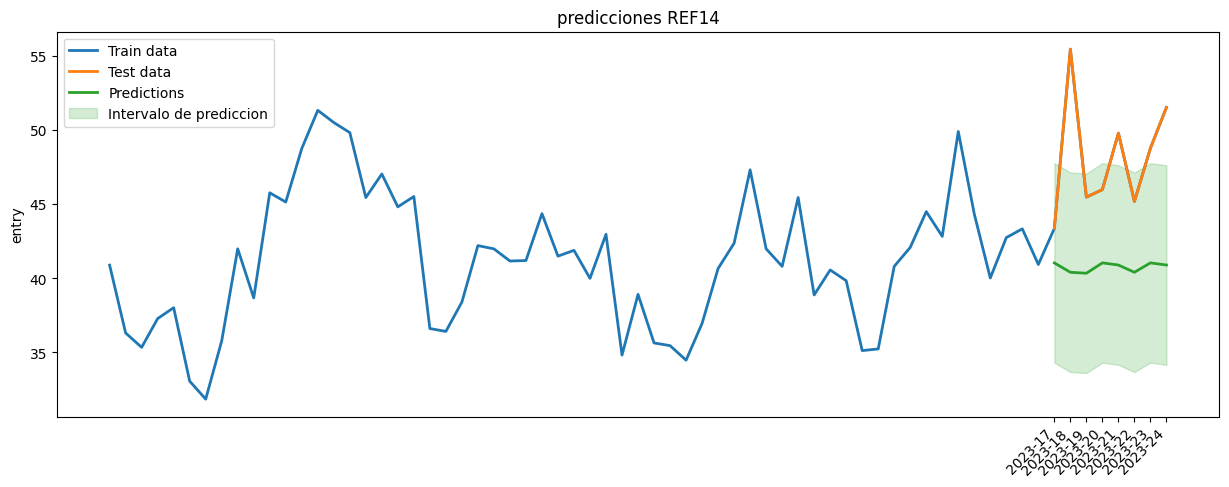

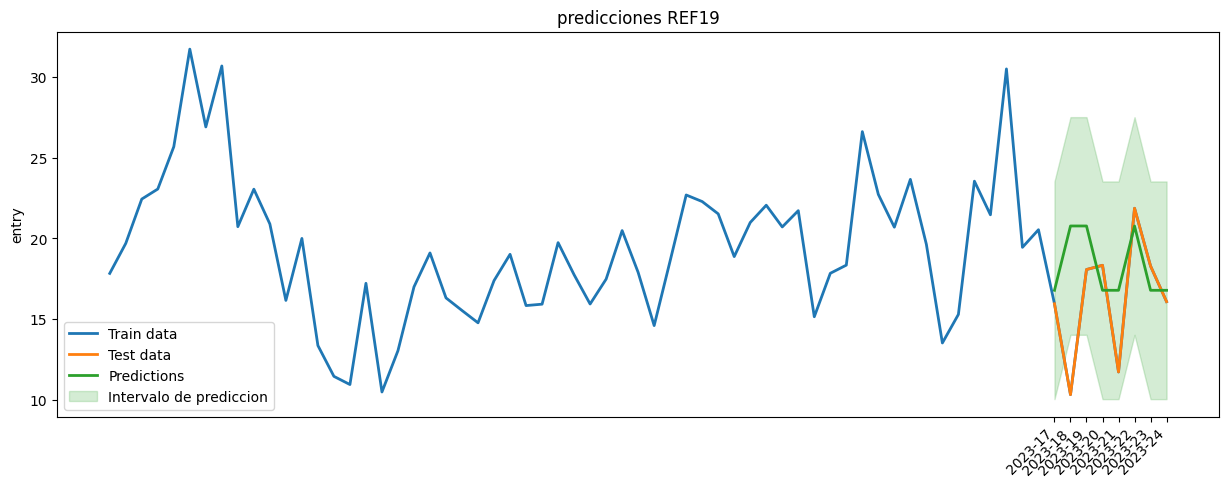

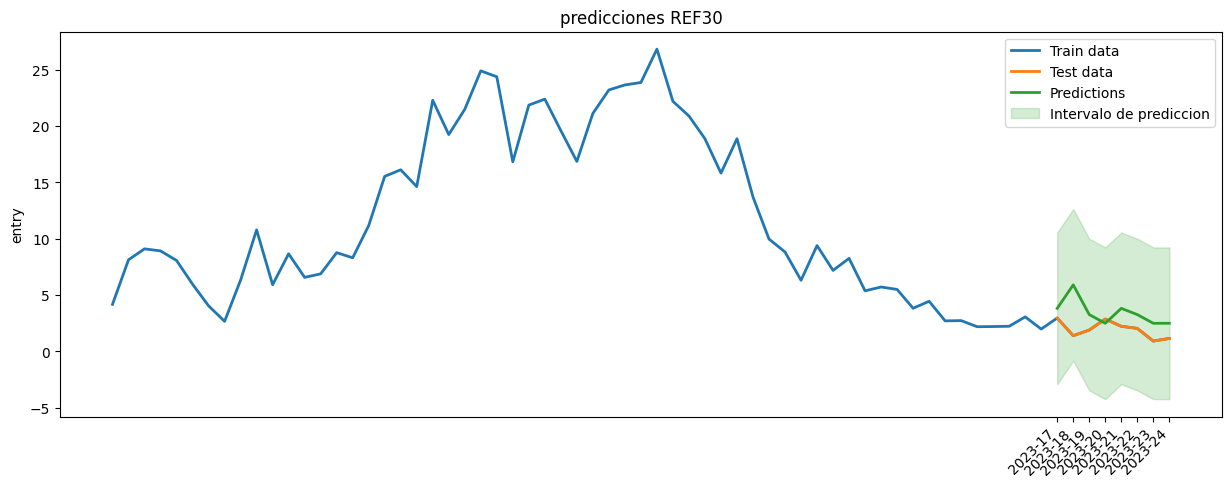

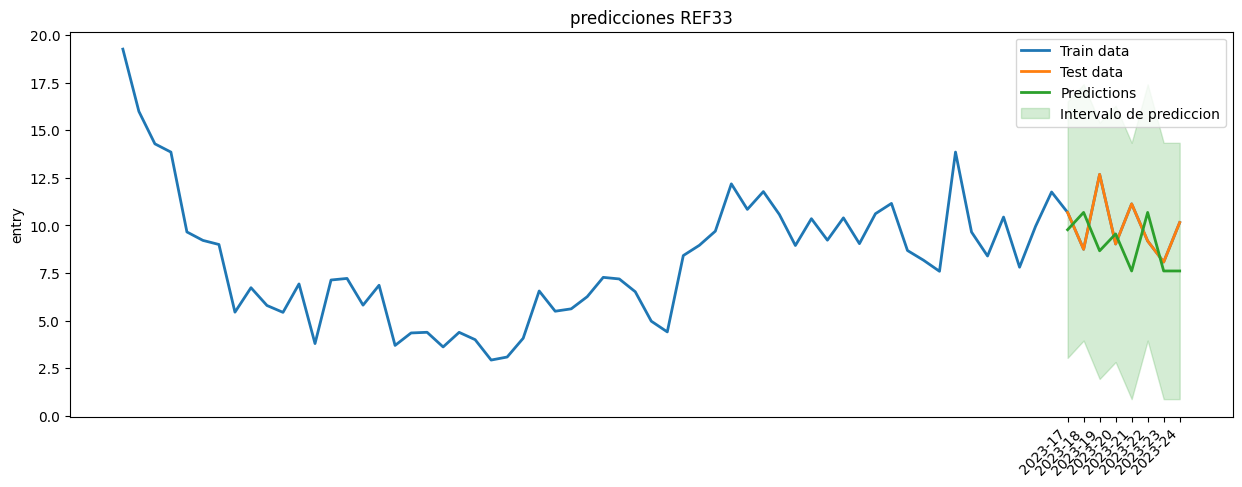

In [425]:
def plot_entry_predictions():
    # Nombres de los DataFrames y los números asociados
    train_numbers = [1, 2, 3, 4, 5]
    test_numbers = [1, 2, 3, 4, 5]
    referencias = ['REF12', 'REF14', 'REF19', 'REF30', 'REF33']

    for train_number, test_number, referencia in zip(train_numbers, test_numbers, referencias):
        # Obtener los DataFrames correspondientes
        dfEntry = globals()[f'dfEntry{train_number}']
        df_test_entry = globals()[f'df_test_entry_{test_number}']

        # Crear el gráfico
        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_ylabel("entry")
        #plt.ylim(10, 100)

        # Trazar datos de entrenamiento, datos de prueba y predicciones
        ax.plot(dfEntry['Fecha'].index, dfEntry['Market_Share'], lw=2, label="Train data", c="C0")
        ax.plot(df_test_entry['fecha'].index, df_test_entry['test'], lw=2, label="Test data", c="C1")
        ax.plot(df_test_entry['fecha'].index, df_test_entry['predichos'], lw=2, c="C2", label="Predictions")

        # Trazar intervalos de predicción
        ax.fill_between(
            df_test_entry['fecha'].index,
            df_test_entry['intervalo_inf'],
            df_test_entry['intervalo_sup'],
            color="C2",
            alpha=0.2,
            label="Intervalo de prediccion",
        )

        ax.legend()

        # Establecer valores del eje x como fechas y rotar las etiquetas para una mejor visualización
        ax.set_xticks(df_test_entry['fecha'].index)
        ax.set_xticklabels(df_test_entry['fecha'], rotation=45, ha="right")
        ax.set_title(f"predicciones {referencia}")

        plt.show()

# Uso de la función para generar los 5 gráficos
plot_entry_predictions()

## Comparación de resultados

In [421]:
lr_r_cuadrado = r2_score(y_test, y_predLR)
lr_rmse = np.sqrt(mean_squared_error(y_test,y_predLR))
lr_mape = mean_absolute_percentage_error(y_test,y_predLR)
lr_mse = mean_squared_error(y_test, y_predLR)
lr_mae = mean_absolute_error(y_test, y_predLR)

rf_r_cuadrado = r2_score(y_test, y_predRF)
rf_rmse = np.sqrt(mean_squared_error(y_test,y_predRF))
rf_mape = mean_absolute_percentage_error(y_test,y_predRF)
rf_mse = mean_squared_error(y_test, y_predRF)
rf_mae = mean_absolute_error(y_test, y_predRF)

gb_r_cuadrado = r2_score(y_test, y_predGB)
gb_rmse = np.sqrt(mean_squared_error(y_test,y_predGB))
gb_mape = mean_absolute_percentage_error(y_test,y_predGB)
gb_mse = mean_squared_error(y_test, y_predGB)
gb_mae = mean_absolute_error(y_test, y_predGB)

lgbm_r_cuadrado = r2_score(y_test, y_predLGBM)
lgbm_rmse = np.sqrt(mean_squared_error(y_test,y_predLGBM))
lgbm_mape = mean_absolute_percentage_error(y_test,y_predLGBM)
lgbm_mse = mean_squared_error(y_test, y_predLGBM)
lgbm_mae = mean_absolute_error(y_test, y_predLGBM)

xgboost_r_cuadrado = r2_score(y_test, y_predXGBOOST)
xgboost_rmse = np.sqrt(mean_squared_error(y_test,y_predXGBOOST))
xgboost_mape = mean_absolute_percentage_error(y_test,y_predXGBOOST)
xgboost_mse = mean_squared_error(y_test, y_predXGBOOST)
xgboost_mae = mean_absolute_error(y_test, y_predXGBOOST)



In [422]:
data = {
    'Modelo': ['LinearRegression','Random Forest','Gradient boosting','LightGBM', 'XGBoost'],
    'R_cuadrado': [lr_r_cuadrado,rf_r_cuadrado, gb_r_cuadrado,lgbm_r_cuadrado,xgboost_r_cuadrado],
    'MSE': [lr_mse,rf_mse, gb_mse,lgbm_mse,xgboost_mse],
    'MAPE': [lr_mape,rf_mape, gb_mape,lgbm_mape,xgboost_mape],
    'RMSE': [lr_rmse,rf_rmse, gb_rmse,lgbm_rmse,xgboost_rmse],
    'MAE': [lr_mae,rf_mae, gb_mae,lgbm_mae,xgboost_mae]
}

metricas = pd.DataFrame(data)
print(metricas)

              Modelo  R_cuadrado   MSE  MAPE  RMSE  MAE
0   LinearRegression        0.66 87.91  0.95  9.38 7.41
1      Random Forest        0.91 22.52  0.43  4.75 3.46
2  Gradient boosting        0.93 18.63  0.27  4.32 2.94
3           LightGBM        0.91 22.28  0.78  4.72 3.70
4            XGBoost        0.92 20.37  0.34  4.51 3.14
